In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully")

✅ Libraries imported successfully


In [ ]:
# Define data folder path
# For local: data_folder = 'additional_sleep_data'
# For Google Colab:
from google.colab import drive
drive.mount('/content/drive')

data_folder = '/content/drive/MyDrive/AI4Food/DS8_SleepActivity/additional_sleep_data'

# Find all CSV files
csv_pattern = os.path.join(data_folder, '*_additional_sleep_data.csv')
file_paths = glob.glob(csv_pattern)

print(f"📁 Found {len(file_paths)} patient files")
print(f"\nFirst 5 files:")
for f in sorted(file_paths)[:5]:
    print(f"  - {os.path.basename(f)}")

Mounted at /content/drive
📁 Found 95 patient files

First 5 files:
  - A4F_10021_additional_sleep_data.csv
  - A4F_10141_additional_sleep_data.csv
  - A4F_10355_additional_sleep_data.csv
  - A4F_10660_additional_sleep_data.csv
  - A4F_10709_additional_sleep_data.csv


## Load and Clean Data

In [ ]:
# Load all patient data
all_data = []

for file_path in sorted(file_paths):
    patient_id = os.path.basename(file_path).split('_additional')[0]
    df = pd.read_csv(file_path)
    df['patient_id'] = patient_id
    all_data.append(df)

df_all = pd.concat(all_data, ignore_index=True)

print(f"Total records loaded: {len(df_all)}")
print(f"Total patients: {df_all['patient_id'].nunique()}")
print(f"\nDataset shape: {df_all.shape}")

✅ Total records loaded: 1651
✅ Total patients: 95

Dataset shape: (1651, 12)


In [ ]:
# Filter to main sleep only and drop NA records
print("Filtering data...")
print(f"Total records: {len(df_all)}")

# Filter to main sleep
df_main = df_all[df_all['main_sleep'] == True].copy()
print(f"Main sleep records: {len(df_main)} ({len(df_main)/len(df_all)*100:.1f}%)")

# Drop records with NA stage data
stage_cols = ['minutes_in_deep_sleep', 'minutes_in_light_sleep', 'minutes_in_rem']
df_clean = df_main.dropna(subset=stage_cols).copy()
print(f"After removing NA: {len(df_clean)} records ({len(df_clean)/len(df_main)*100:.1f}% retention)")

print(f"\nClean dataset: {len(df_clean)} nights from {df_clean['patient_id'].nunique()} patients")

Filtering data...
Total records: 1651
Main sleep records: 1426 (86.4%)
After removing NA: 1374 records (96.4% retention)

✅ Clean dataset: 1374 nights from 95 patients


In [ ]:
# Calculate derived features
df_clean['total_sleep_hours'] = df_clean['minutes_asleep'] / 60
df_clean['deep_sleep_pct'] = (df_clean['minutes_in_deep_sleep'] / df_clean['minutes_asleep']) * 100
df_clean['rem_sleep_pct'] = (df_clean['minutes_in_rem'] / df_clean['minutes_asleep']) * 100
df_clean['light_sleep_pct'] = (df_clean['minutes_in_light_sleep'] / df_clean['minutes_asleep']) * 100
df_clean['sleep_efficiency'] = (df_clean['minutes_asleep'] / df_clean['minutes_in_bed']) * 100

# Convert timestamps
df_clean['start_datetime'] = pd.to_datetime(df_clean['start_time'])
df_clean['date'] = df_clean['start_datetime'].dt.date

print("✅ Derived features calculated")
print(f"\nSample data:")
df_clean[['patient_id', 'date', 'total_sleep_hours', 'deep_sleep_pct',
          'rem_sleep_pct', 'light_sleep_pct']].head()

✅ Derived features calculated

Sample data:


,patient_id,date,total_sleep_hours,deep_sleep_pct,rem_sleep_pct,light_sleep_pct
0,A4F_10021,2022-06-08,5.933333,28.370787,24.438202,47.191011
2,A4F_10021,2022-06-09,5.100000,18.300654,21.895425,59.803922
3,A4F_10021,2022-06-10,7.033333,14.928910,27.488152,57.582938
4,A4F_10021,2022-06-11,7.366667,18.778281,26.470588,54.751131
5,A4F_10021,2022-06-12,7.866667,21.186441,25.423729,53.389831


## Component Scoring Functions

In [ ]:
def calculate_deep_sleep_score(deep_pct):
    """
    Calculate deep sleep component score (0-100).
    Optimal range: 13-23%
    """
    if deep_pct < 13:
        return (deep_pct / 13) * 50
    elif 13 <= deep_pct <= 23:
        return 100
    else:
        return max(0, 100 - ((deep_pct - 23) * 5))

def calculate_rem_sleep_score(rem_pct):
    """
    Calculate REM sleep component score (0-100).
    Optimal range: 15-25%
    """
    if rem_pct < 15:
        return (rem_pct / 15) * 60
    elif 15 <= rem_pct <= 25:
        return 100
    else:
        return max(0, 100 - ((rem_pct - 25) * 3))

def calculate_light_sleep_score(light_pct):
    """
    Calculate light sleep component score (0-100).
    Optimal range: 45-65%
    """
    if light_pct < 45:
        return 80
    elif 45 <= light_pct <= 65:
        return 100
    else:
        return max(0, 100 - ((light_pct - 65) * 2))

def calculate_duration_score(hours):
    """
    Calculate duration component score (0-100).
    Optimal range: 6-9 hours
    """
    if hours < 6:
        return (hours / 6) * 60
    elif 6 <= hours <= 9:
        return 100
    else:
        return max(0, 100 - ((hours - 9) * 10))

print("✅ Scoring functions defined")

✅ Scoring functions defined


## Calculate Quality Scores

In [ ]:
# Calculate scores for all records
print("Calculating quality scores...")

results = []
for idx, row in df_clean.iterrows():
    deep_score = calculate_deep_sleep_score(row['deep_sleep_pct'])
    rem_score = calculate_rem_sleep_score(row['rem_sleep_pct'])
    light_score = calculate_light_sleep_score(row['light_sleep_pct'])
    duration_score = calculate_duration_score(row['total_sleep_hours'])

    # Composite quality score: Deep(40%) + REM(30%) + Light(20%) + Duration(10%)
    quality_score = (deep_score * 0.4 +
                    rem_score * 0.3 +
                    light_score * 0.2 +
                    duration_score * 0.1)

    results.append({
        'deep_score': deep_score,
        'rem_score': rem_score,
        'light_score': light_score,
        'duration_score': duration_score,
        'quality_score': quality_score
    })

scores_df = pd.DataFrame(results)
df_scored = pd.concat([df_clean.reset_index(drop=True), scores_df], axis=1)

# Add quality category
def classify_quality(score):
    if score >= 90:
        return 'Excellent'
    elif score >= 80:
        return 'Good'
    elif score >= 70:
        return 'Fair'
    elif score >= 60:
        return 'Poor'
    else:
        return 'Very Poor'

df_scored['quality_category'] = df_scored['quality_score'].apply(classify_quality)

print(f"Quality scores calculated for {len(df_scored)} nights")
print(f"\nQuality Score Statistics:")
print(f"  Mean: {df_scored['quality_score'].mean():.1f}")
print(f"  Median: {df_scored['quality_score'].median():.1f}")
print(f"  Std Dev: {df_scored['quality_score'].std():.1f}")
print(f"  Range: {df_scored['quality_score'].min():.1f} - {df_scored['quality_score'].max():.1f}")

Calculating quality scores...
✅ Quality scores calculated for 1374 nights

Quality Score Statistics:
  Mean: 84.6
  Median: 92.2
  Std Dev: 16.0
  Range: 19.5 - 100.0


In [ ]:
# Display sample results
print("Sample scored data:")
df_scored[['patient_id', 'date', 'quality_score', 'quality_category',
           'deep_score', 'rem_score', 'light_score', 'duration_score']].head(10)

Sample scored data:


,patient_id,date,quality_score,quality_category,deep_score,rem_score,light_score,duration_score
0,A4F_10021,2022-06-08,85.191760,Good,73.146067,100.000000,100.000000,59.333333
1,A4F_10021,2022-06-09,95.100000,Excellent,100.000000,100.000000,100.000000,51.000000
2,A4F_10021,2022-06-10,97.760664,Excellent,100.000000,92.535545,100.000000,100.000000
3,A4F_10021,2022-06-11,98.676471,Excellent,100.000000,95.588235,100.000000,100.000000
4,A4F_10021,2022-06-12,99.618644,Excellent,100.000000,98.728814,100.000000,100.000000
5,A4F_10021,2022-06-14,85.918047,Good,100.000000,68.949045,100.000000,52.333333
6,A4F_10021,2022-06-15,67.651035,Poor,37.071362,90.963855,100.000000,55.333333
7,A4F_10021,2022-06-16,95.325485,Excellent,100.000000,84.418283,100.000000,100.000000
8,A4F_10021,2022-06-17,72.619273,Fair,45.397226,100.000000,96.885246,50.833333
9,A4F_10141,2022-06-07,94.406569,Excellent,100.000000,100.000000,96.449511,51.166667


## Summary Statistics

In [ ]:
print("="*70)
print("METHOD 1: SLEEP ARCHITECTURE QUALITY SCORE - SUMMARY")
print("="*70)

print(f"\nDataset: {len(df_scored)} nights from {df_scored['patient_id'].nunique()} patients")

print(f"\nOverall Quality Score:")
print(f"  Mean: {df_scored['quality_score'].mean():.1f} ± {df_scored['quality_score'].std():.1f}")
print(f"  Median: {df_scored['quality_score'].median():.1f}")
print(f"  Range: {df_scored['quality_score'].min():.1f} - {df_scored['quality_score'].max():.1f}")

print(f"\nComponent Scores:")
print(f"  Deep Sleep:  {df_scored['deep_score'].mean():.1f} ± {df_scored['deep_score'].std():.1f}")
print(f"  REM Sleep:   {df_scored['rem_score'].mean():.1f} ± {df_scored['rem_score'].std():.1f}")
print(f"  Light Sleep: {df_scored['light_score'].mean():.1f} ± {df_scored['light_score'].std():.1f}")
print(f"  Duration:    {df_scored['duration_score'].mean():.1f} ± {df_scored['duration_score'].std():.1f}")

print(f"\nQuality Distribution:")
quality_order = ['Excellent', 'Good', 'Fair', 'Poor', 'Very Poor']
for category in quality_order:
    count = (df_scored['quality_category'] == category).sum()
    pct = (count / len(df_scored)) * 100
    print(f"  {category:12s}: {count:4d} nights ({pct:5.1f}%)")

METHOD 1: SLEEP ARCHITECTURE QUALITY SCORE - SUMMARY

Dataset: 1374 nights from 95 patients

Overall Quality Score:
  Mean: 84.6 ± 16.0
  Median: 92.2
  Range: 19.5 - 100.0

Component Scores:
  Deep Sleep:  81.4 ± 28.5
  REM Sleep:   84.9 ± 23.0
  Light Sleep: 93.6 ± 10.2
  Duration:    78.8 ± 25.2

Quality Distribution:
  Excellent   :  727 nights ( 52.9%)
  Good        :  163 nights ( 11.9%)
  Fair        :  246 nights ( 17.9%)
  Poor        :  109 nights (  7.9%)
  Very Poor   :  129 nights (  9.4%)


## Visualization 1: Quality Score Distribution

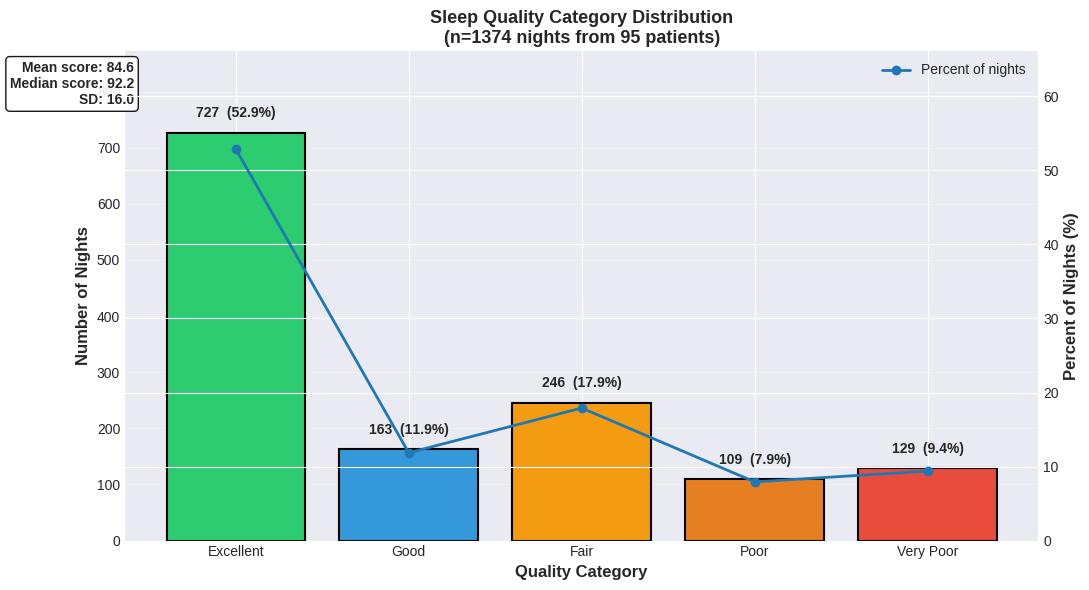

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(11, 6))

quality_order = ['Excellent', 'Good', 'Fair', 'Poor', 'Very Poor']
quality_counts = df_scored['quality_category'].value_counts().reindex(quality_order, fill_value=0)
n = len(df_scored)

# Keep your colors
colors = ['#2ecc71', '#3498db', '#f39c12', '#e67e22', '#e74c3c']

# Bars
x = np.arange(len(quality_order))
bars = ax.bar(x, quality_counts.values, color=colors, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Number of Nights', fontsize=12, fontweight='bold')
ax.set_xlabel('Quality Category', fontsize=12, fontweight='bold')
ax.set_title(
    f'Sleep Quality Category Distribution\n(n={n} nights from {df_scored["patient_id"].nunique()} patients)',
    fontsize=13, fontweight='bold'
)
ax.set_xticks(x)
ax.set_xticklabels(quality_order)
ax.grid(axis='y', alpha=0.3)

# Add headroom so labels don't hit the top
ymax = max(1, quality_counts.max())
ax.set_ylim(0, ymax * 1.20)

# Count + percent labels above each bar
for bar, count in zip(bars, quality_counts.values):
    if count > 0:
        pct = (count / n) * 100 if n > 0 else 0
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + ymax * 0.03,
            f'{int(count)}  ({pct:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=10
        )

# Secondary axis for percentage + line marker
ax2 = ax.twinx()
percentages = (quality_counts.values / n) * 100 if n > 0 else np.zeros_like(quality_counts.values)
ax2.plot(x, percentages, marker='o', linewidth=2, label='Percent of nights')
ax2.set_ylabel('Percent of Nights (%)', fontsize=12, fontweight='bold')
ax2.set_ylim(0, max(5, percentages.max() * 1.25))

# Stats box (your original, slightly cleaner placement)
mean = df_scored["quality_score"].mean()
median = df_scored["quality_score"].median()
sd = df_scored["quality_score"].std()

stats_text = f'Mean score: {mean:.1f}\nMedian score: {median:.1f}\nSD: {sd:.1f}'
ax.text(
    0.01, 0.98, stats_text, transform=ax.transAxes,
    fontsize=10, va='top', ha='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    fontweight='bold'
)

# Legend for the % line
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Visualization 2: Component Scores Comparison

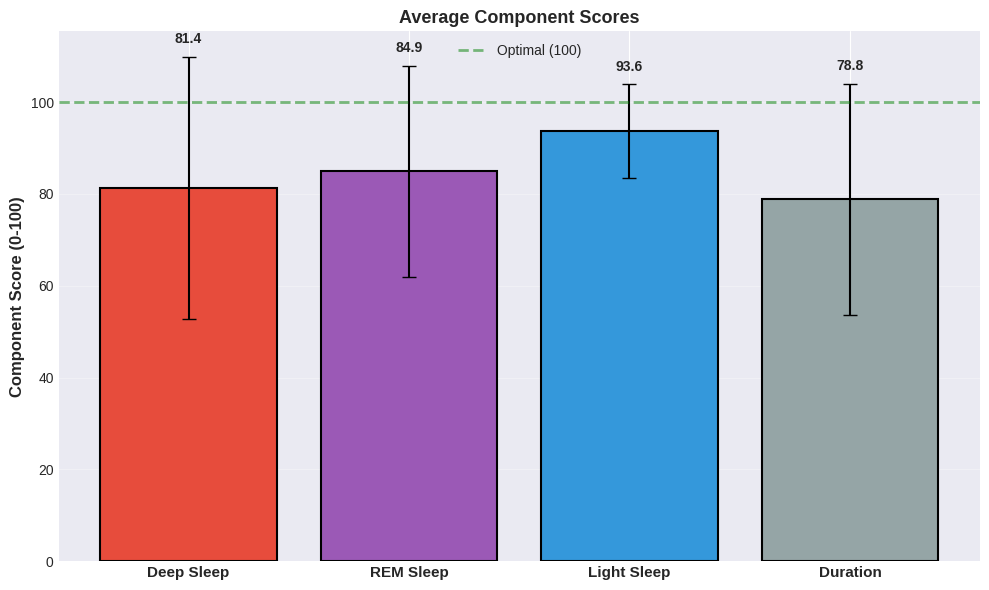

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

components = ['Deep Sleep', 'REM Sleep', 'Light Sleep', 'Duration']
means = [df_scored['deep_score'].mean(), df_scored['rem_score'].mean(),
         df_scored['light_score'].mean(), df_scored['duration_score'].mean()]
stds = [df_scored['deep_score'].std(), df_scored['rem_score'].std(),
        df_scored['light_score'].std(), df_scored['duration_score'].std()]

x = np.arange(len(components))
bars = ax.bar(x, means, yerr=stds, capsize=5,
               color=['#e74c3c', '#9b59b6', '#3498db', '#95a5a6'],
               edgecolor='black', linewidth=1.5)

ax.set_xticks(x)
ax.set_xticklabels(components, fontweight='bold', fontsize=11)
ax.set_ylabel('Component Score (0-100)', fontsize=12, fontweight='bold')
ax.set_title('Average Component Scores', fontsize=13, fontweight='bold')
ax.axhline(y=100, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Optimal (100)')
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=10)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    ax.text(bar.get_x() + bar.get_width()/2., mean + std + 3,
             f'{mean:.1f}', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## Visualization 3: Sleep Stage Composition for 3 Patients

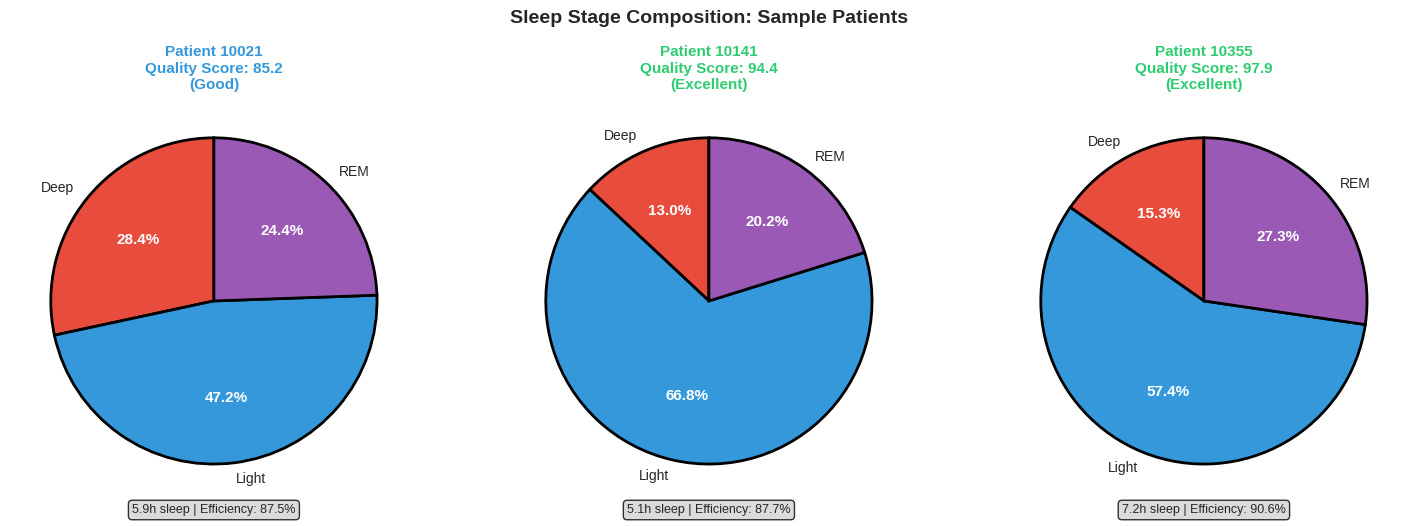

In [ ]:
# Select 3 patients to display
selected_patients = df_scored['patient_id'].unique()[:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, patient_id in enumerate(selected_patients):
    ax = axes[i]

    # Get first night for this patient
    patient_night = df_scored[df_scored['patient_id'] == patient_id].iloc[0]

    # Stage data
    stages = ['Deep', 'Light', 'REM']
    percentages = [patient_night['deep_sleep_pct'],
                  patient_night['light_sleep_pct'],
                  patient_night['rem_sleep_pct']]
    colors_pie = ['#e74c3c', '#3498db', '#9b59b6']

    # Create pie chart
    wedges, texts, autotexts = ax.pie(percentages, labels=stages, colors=colors_pie,
                                       autopct='%1.1f%%', startangle=90,
                                       wedgeprops={'edgecolor': 'black', 'linewidth': 2})

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)

    # Determine quality level
    quality = patient_night['quality_score']
    if quality >= 90:
        quality_label, quality_color = 'Excellent', '#2ecc71'
    elif quality >= 80:
        quality_label, quality_color = 'Good', '#3498db'
    elif quality >= 70:
        quality_label, quality_color = 'Fair', '#f39c12'
    else:
        quality_label, quality_color = 'Poor/Very Poor', '#e74c3c'

    # Title with quality score
    title_text = f'{patient_id.replace("A4F_", "Patient ")}\nQuality Score: {quality:.1f}\n({quality_label})'
    ax.set_title(title_text, fontsize=11, fontweight='bold', color=quality_color)

    # Add details below
    details = f'{patient_night["total_sleep_hours"]:.1f}h sleep | Efficiency: {patient_night["sleep_efficiency"]:.1f}%'
    ax.text(0, -1.3, details, ha='center', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.suptitle('Sleep Stage Composition: Sample Patients', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

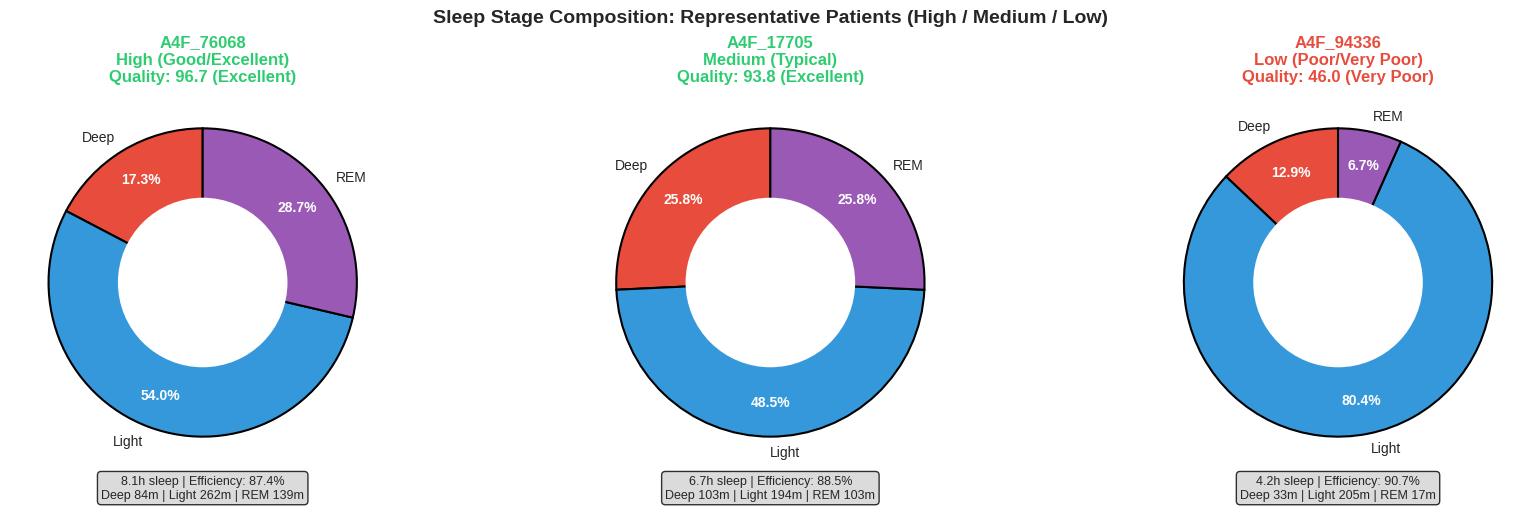

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Helper: pick representative patients
# ----------------------------
patient_means = df_scored.groupby('patient_id')['quality_score'].mean().sort_values()

low_patient = patient_means.index[0]
high_patient = patient_means.index[-1]

overall_median = df_scored['quality_score'].median()
mid_patient = (patient_means - overall_median).abs().idxmin()

selected_patients = [
    (high_patient, "High (Good/Excellent)"),
    (mid_patient, "Medium (Typical)"),
    (low_patient, "Low (Poor/Very Poor)")
]

# ----------------------------
# Helper: quality label/color (same as your logic)
# ----------------------------
def quality_bucket(score):
    if score >= 90:
        return 'Excellent', '#2ecc71'
    elif score >= 80:
        return 'Good', '#3498db'
    elif score >= 70:
        return 'Fair', '#f39c12'
    elif score >= 60:
        return 'Poor', '#e67e22'
    else:
        return 'Very Poor', '#e74c3c'

# ----------------------------
# Plot: donut charts (one per representative patient)
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(17, 5), constrained_layout=True)

stage_labels = ['Deep', 'Light', 'REM']
stage_colors = ['#e74c3c', '#3498db', '#9b59b6']

for ax, (patient_id, group_label) in zip(axes, selected_patients):

    # pick one representative night: closest night to that patient's mean score
    p = df_scored[df_scored['patient_id'] == patient_id].copy()
    target = p['quality_score'].mean()
    patient_night = p.iloc[(p['quality_score'] - target).abs().argsort()[:1]].iloc[0]

    # percentages
    pct = np.array([
        patient_night['deep_sleep_pct'],
        patient_night['light_sleep_pct'],
        patient_night['rem_sleep_pct']
    ])

    # minutes (more interpretable than % alone)
    mins = np.array([
        patient_night['minutes_in_deep_sleep'],
        patient_night['minutes_in_light_sleep'],
        patient_night['minutes_in_rem']
    ])

    # donut chart
    wedges, _texts, autotexts = ax.pie(
        pct,
        labels=stage_labels,
        colors=stage_colors,
        startangle=90,
        autopct='%1.1f%%',
        pctdistance=0.78,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
    )

    # make it a donut
    center_circle = plt.Circle((0, 0), 0.55, fc='white')
    ax.add_artist(center_circle)

    # style % labels
    for t in autotexts:
        t.set_fontweight('bold')
        t.set_fontsize(10)
        t.set_color('white')

    # title: patient + quality
    q = float(patient_night['quality_score'])
    q_label, q_color = quality_bucket(q)
    ax.set_title(
        f'{patient_id}\n{group_label}\nQuality: {q:.1f} ({q_label})',
        fontweight='bold',
        color=q_color
    )

    # details: hours + (optional) efficiency + stage minutes
    sleep_hours = patient_night.get('total_sleep_hours', np.nan)
    eff = patient_night.get('sleep_efficiency', None)  # only if exists

    minutes_line = f"Deep {int(mins[0])}m | Light {int(mins[1])}m | REM {int(mins[2])}m"
    if eff is not None and not np.isnan(eff):
        details = f"{sleep_hours:.1f}h sleep | Efficiency: {eff:.1f}%\n{minutes_line}"
    else:
        details = f"{sleep_hours:.1f}h sleep\n{minutes_line}"

    ax.text(
        0, -1.25, details,
        ha='center', va='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
    )

plt.suptitle('Sleep Stage Composition: Representative Patients (High / Medium / Low)', fontsize=14, fontweight='bold')
plt.show()


## Visualization 4: Single Patient - 7 Days Timeline

Selected patient: A4F_40008
Displaying 7 nights


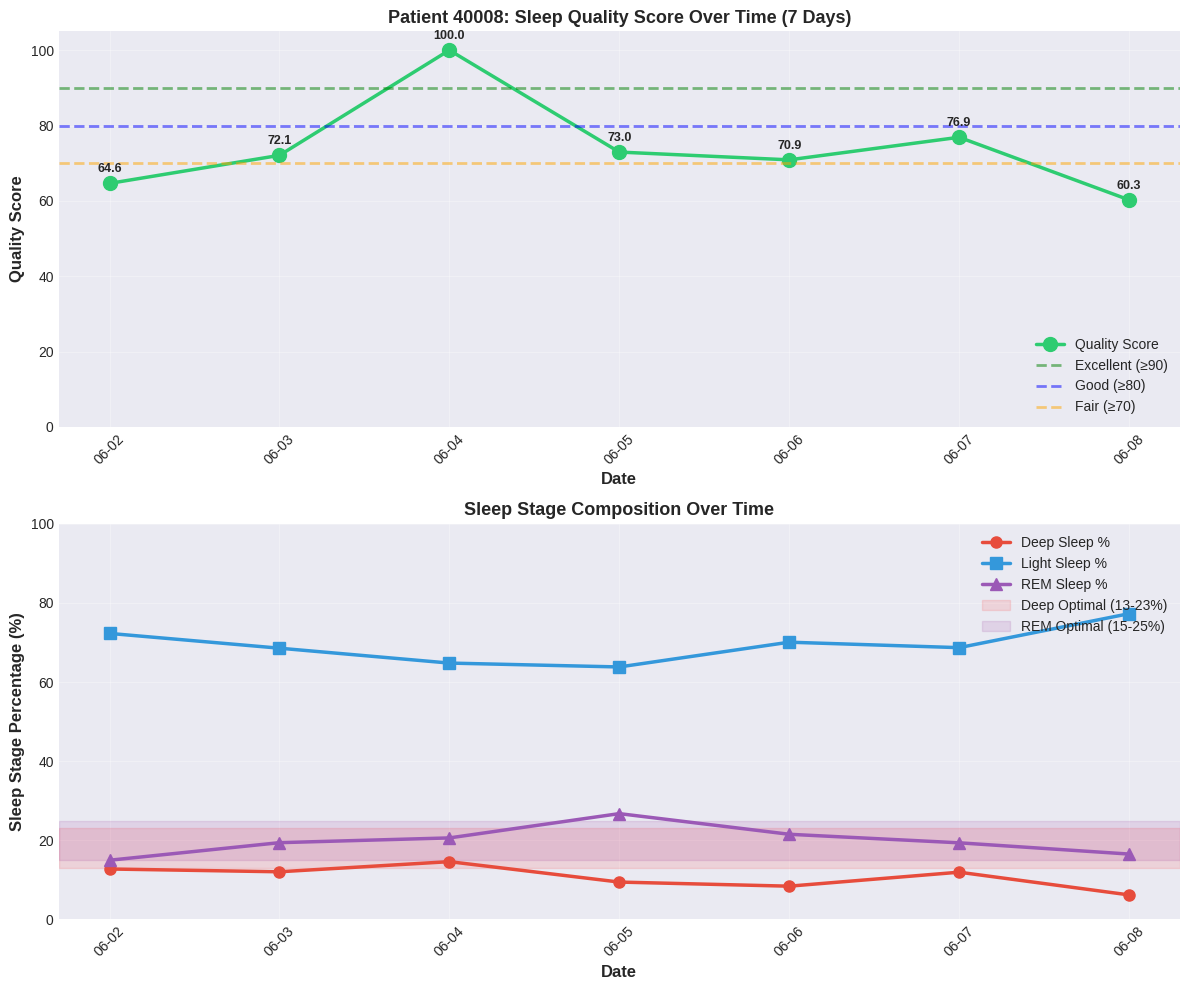


Detailed Data for 7 Days:


,date,quality_score,quality_category,deep_sleep_pct,light_sleep_pct,rem_sleep_pct,total_sleep_hours
413,2022-06-02,64.634136,Poor,12.742382,72.299169,14.958449,6.016667
414,2022-06-03,72.081867,Fair,12.040134,68.561873,19.397993,4.983333
415,2022-06-04,100.000000,Excellent,14.600000,64.800000,20.600000,8.333333
416,2022-06-05,72.952895,Fair,9.438202,63.820225,26.741573,7.416667
417,2022-06-06,70.889966,Fair,8.398950,70.078740,21.522310,6.350000
418,2022-06-07,76.883493,Fair,11.936340,68.700265,19.363395,6.283333
419,2022-06-08,60.265838,Poor,6.194690,77.286136,16.519174,5.650000


In [ ]:
# Select patient with most records
patient_counts = df_scored.groupby('patient_id').size()
selected_patient = patient_counts.idxmax()

# Get first 7 days for this patient
patient_data = df_scored[df_scored['patient_id'] == selected_patient].sort_values('date').head(7)

print(f"Selected patient: {selected_patient}")
print(f"Displaying {len(patient_data)} nights")

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

x = np.arange(len(patient_data))
dates = [str(d)[-5:] for d in patient_data['date']]  # MM-DD format

ax1.plot(x, patient_data['quality_score'], marker='o', linewidth=2.5,
         markersize=10, color='#2ecc71', label='Quality Score')

# Add quality thresholds
ax1.axhline(y=90, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Excellent (≥90)')
ax1.axhline(y=80, color='blue', linestyle='--', alpha=0.5, linewidth=2, label='Good (≥80)')
ax1.axhline(y=70, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Fair (≥70)')

ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Quality Score', fontsize=12, fontweight='bold')
ax1.set_title(f'{selected_patient.replace("A4F_", "Patient ")}: Sleep Quality Score Over Time (7 Days)',
              fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(dates, rotation=45)
ax1.set_ylim(0, 105)
ax1.grid(alpha=0.3)
ax1.legend(loc='lower right', fontsize=10)

# Add value labels
for i, (xi, score) in enumerate(zip(x, patient_data['quality_score'])):
    ax1.text(xi, score + 3, f'{score:.1f}', ha='center', fontweight='bold', fontsize=9)

ax2.plot(x, patient_data['deep_sleep_pct'], marker='o', linewidth=2.5,
         markersize=8, color='#e74c3c', label='Deep Sleep %', linestyle='-')
ax2.plot(x, patient_data['light_sleep_pct'], marker='s', linewidth=2.5,
         markersize=8, color='#3498db', label='Light Sleep %', linestyle='-')
ax2.plot(x, patient_data['rem_sleep_pct'], marker='^', linewidth=2.5,
         markersize=8, color='#9b59b6', label='REM Sleep %', linestyle='-')

# Add optimal range bands
ax2.axhspan(13, 23, alpha=0.1, color='red', label='Deep Optimal (13-23%)')
ax2.axhspan(15, 25, alpha=0.1, color='purple', label='REM Optimal (15-25%)')

ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Sleep Stage Percentage (%)', fontsize=12, fontweight='bold')
ax2.set_title('Sleep Stage Composition Over Time', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(dates, rotation=45)
ax2.set_ylim(0, 100)
ax2.grid(alpha=0.3)
ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

# Display data table
print("\nDetailed Data for 7 Days:")
display_cols = ['date', 'quality_score', 'quality_category', 'deep_sleep_pct',
                'light_sleep_pct', 'rem_sleep_pct', 'total_sleep_hours']
patient_data[display_cols]

In [ ]:
# Save scored data to CSV
output_file = 'method1_sleep_quality_scores.csv'
df_scored.to_csv(output_file, index=False)

print(f"✅ Results saved to: {output_file}")
print(f"\nSaved {len(df_scored)} records with quality scores")
print(f"\nColumns in saved file:")
print(list(df_scored.columns))

✅ Results saved to: method1_sleep_quality_scores.csv

Saved 1374 records with quality scores

Columns in saved file:
['sleep_id', 'start_time', 'end_time', 'duration', 'minutes_asleep', 'minutes_awake', 'minutes_in_bed', 'main_sleep', 'minutes_in_deep_sleep', 'minutes_in_light_sleep', 'minutes_in_rem', 'patient_id', 'total_sleep_hours', 'deep_sleep_pct', 'rem_sleep_pct', 'light_sleep_pct', 'sleep_efficiency', 'start_datetime', 'date', 'deep_score', 'rem_score', 'light_score', 'duration_score', 'quality_score', 'quality_category']


METHOD 2: SLEEP CONSISTENCY & VARIABILITY METRICS

Calculating variability metrics for all patients...
✅ Variability metrics calculated for 95 patients
   (Excluded 0 patients with <3 nights)

VARIABILITY SUMMARY STATISTICS

Population Variability:
  Mean MAD: 0.95 hours
  Mean Std Dev: 1.04 hours
  Mean CV: 17.3%

Consistency Distribution:
  Highly Consistent     :  12 patients ( 12.6%)
  Moderately Consistent :  44 patients ( 46.3%)
  Variable              :  30 patients ( 31.6%)
  Highly Variable       :   9 patients (  9.5%)

Sleep Debt:
  Mean cumulative deficit: 14.6 hours
  Mean % nights in debt: 74.4%

Day-to-Day Changes:
  Mean absolute difference: 1.17 hours
  Mean % consistent nights: 28.1%


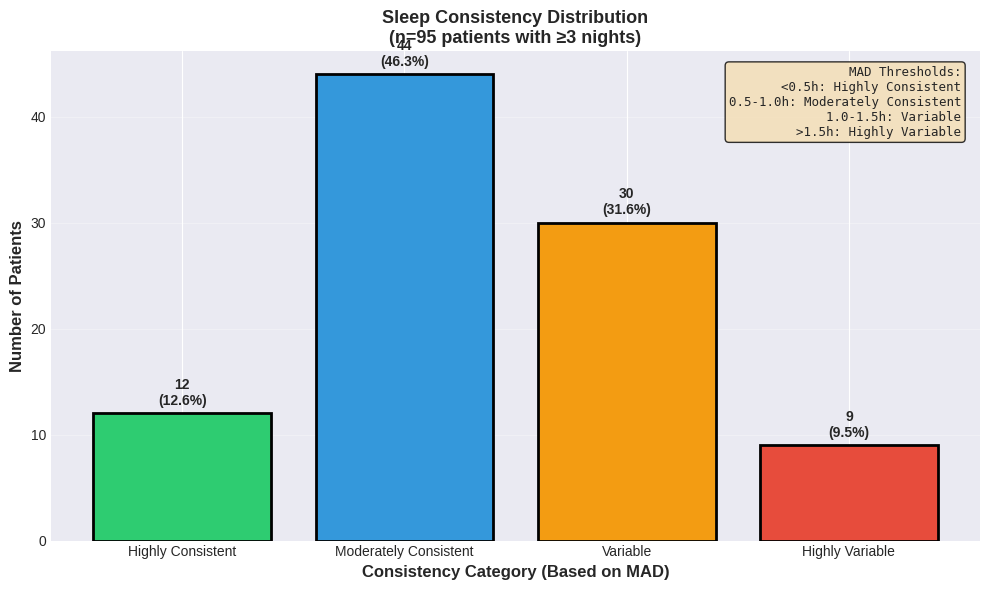

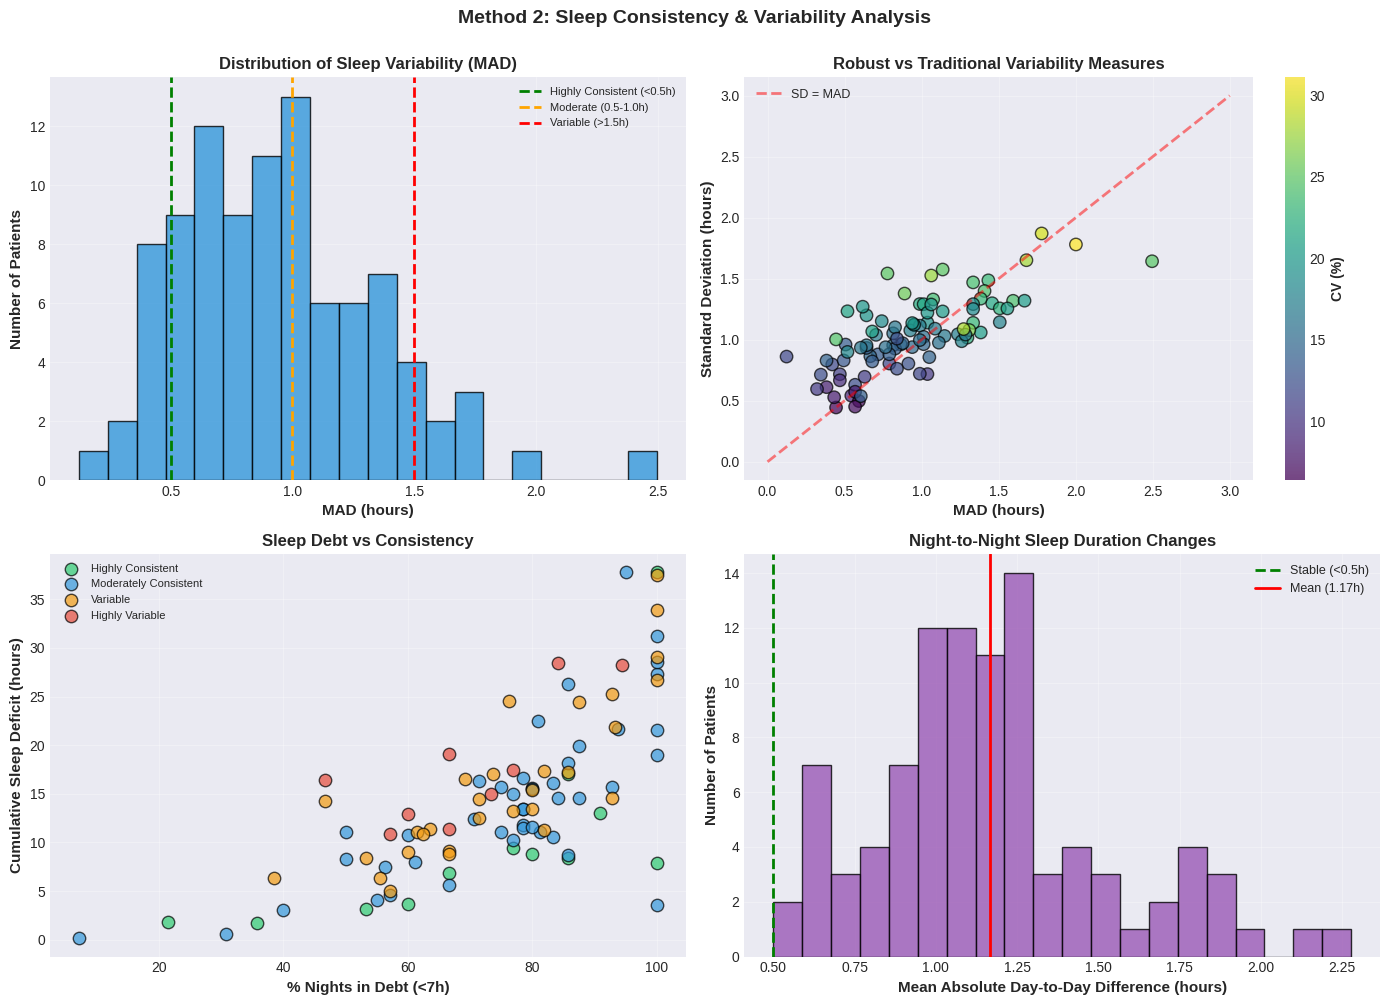

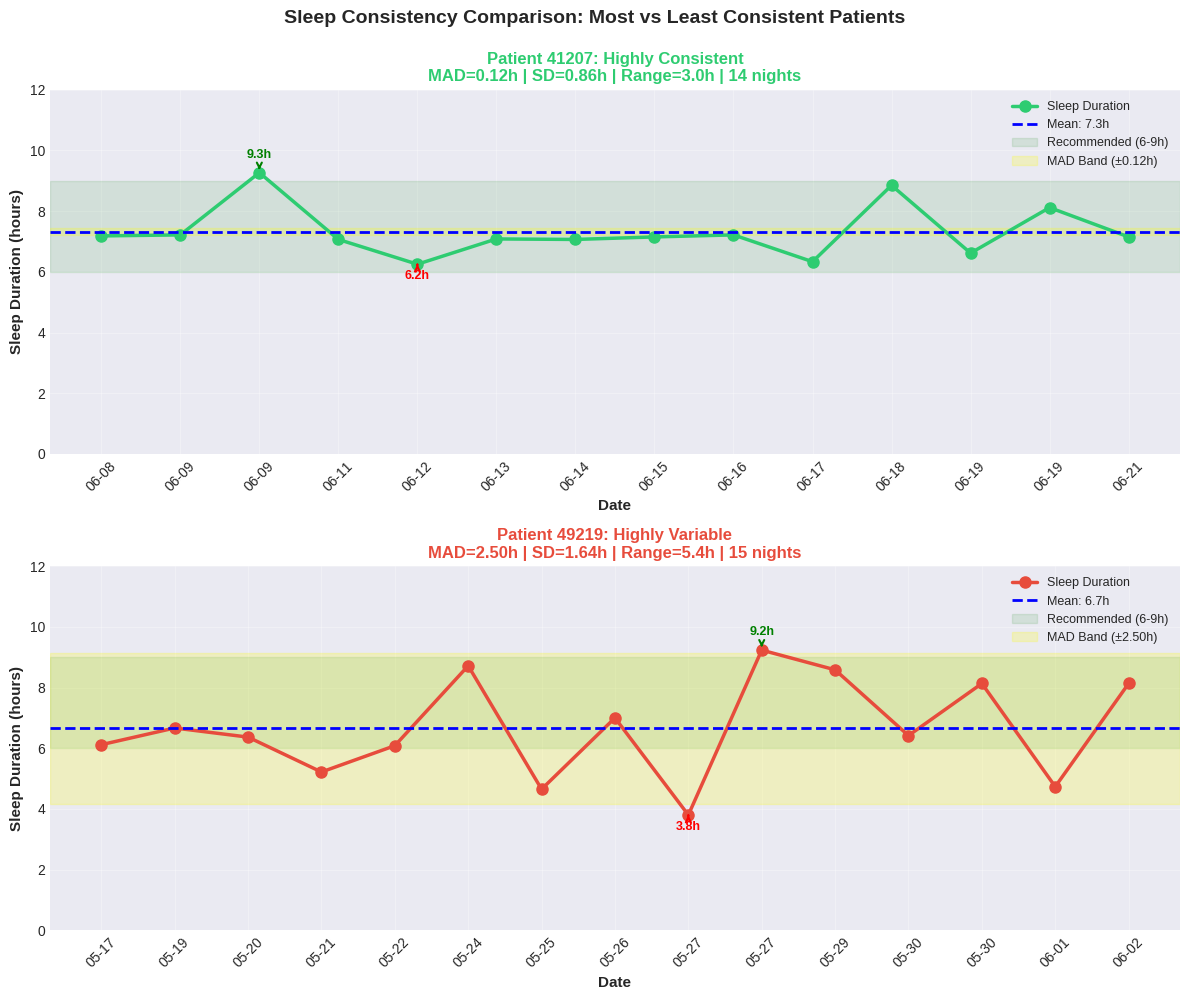

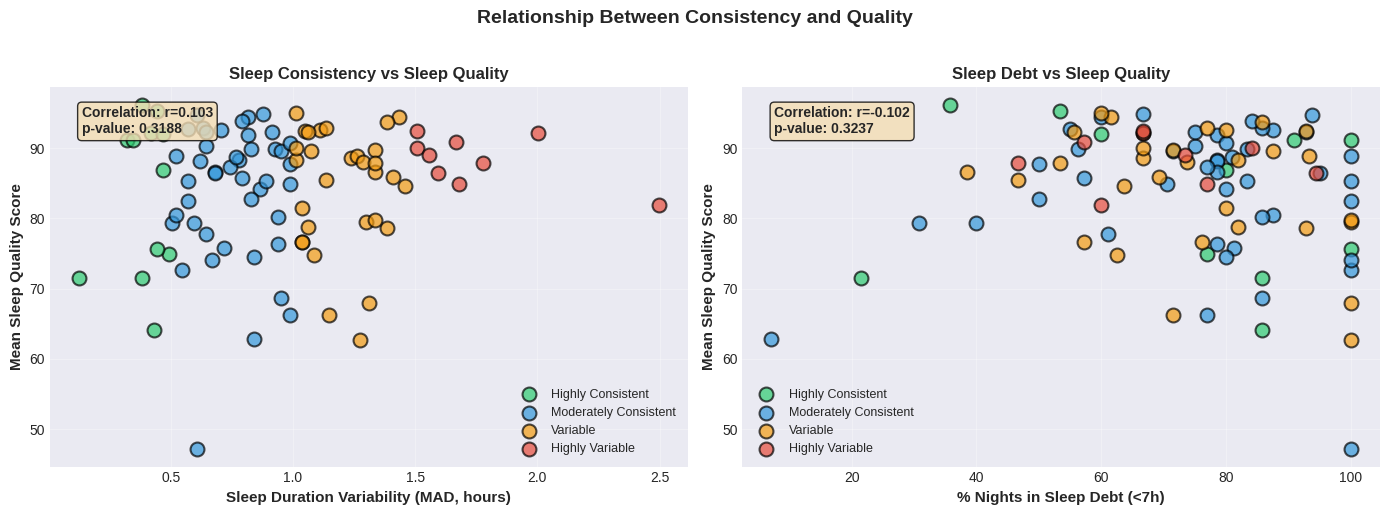


TOP 5 MOST CONSISTENT PATIENTS
patient_id  n_nights  mad  std  mean_sleep consistency_category  mean_quality
 A4F_41207        14 0.12 0.86        7.33    Highly Consistent         71.47
 A4F_84962         6 0.32 0.60        5.69    Highly Consistent         91.11
 A4F_91516        11 0.35 0.71        5.86    Highly Consistent         91.21
 A4F_45118        14 0.38 0.83        5.86    Highly Consistent         71.59
 A4F_76068        14 0.38 0.61        7.22    Highly Consistent         96.22

TOP 5 LEAST CONSISTENT PATIENTS (Most Variable)
patient_id  n_nights  mad  std  mean_sleep consistency_category  mean_quality
 A4F_49219        15 2.50 1.64        6.66      Highly Variable         81.96
 A4F_42312        12 2.00 1.78        5.72      Highly Variable         92.24
 A4F_98453        15 1.78 1.87        6.35      Highly Variable         87.97
 A4F_56279        13 1.68 1.65        5.94      Highly Variable         84.90
 A4F_97386        14 1.67 1.32        6.57      Highly Variab

In [ ]:


def calculate_variability_metrics(patient_data):
    """
    Calculate comprehensive sleep variability metrics for one patient.

    Parameters:
    -----------
    patient_data : DataFrame
        Sleep data for single patient, sorted by date

    Returns:
    --------
    metrics : dict
        Dictionary containing all variability metrics
    """
    sleep_hours = patient_data['total_sleep_hours'].values

    # Basic variability
    overall_std = np.std(sleep_hours, ddof=1)
    overall_mean = np.mean(sleep_hours)
    overall_cv = (overall_std / overall_mean) * 100 if overall_mean > 0 else 0
    overall_range = np.max(sleep_hours) - np.min(sleep_hours)

    # Robust variability (less sensitive to outliers)
    from scipy.stats import median_abs_deviation
    mad = median_abs_deviation(sleep_hours, scale='normal')
    q1, q3 = np.percentile(sleep_hours, [25, 75])
    iqr = q3 - q1

    # Day-to-day changes
    daily_diff = np.diff(sleep_hours)
    mean_abs_diff = np.mean(np.abs(daily_diff))
    median_abs_diff = np.median(np.abs(daily_diff))

    # Sleep debt accumulation (hours below 7h target)
    cumulative_deficit = np.sum(np.maximum(0, 7 - sleep_hours))
    days_in_debt = np.sum(sleep_hours < 7)

    # Consistency categories
    consistent_days = np.sum(np.abs(daily_diff) < 0.5)  # <30min change
    variable_days = np.sum(np.abs(daily_diff) > 1.5)     # >90min change

    metrics = {
        'n_nights': len(sleep_hours),
        'mean_sleep': overall_mean,
        'median_sleep': np.median(sleep_hours),
        'std': overall_std,
        'cv': overall_cv,
        'range': overall_range,
        'mad': mad,
        'iqr': iqr,
        'mean_abs_diff': mean_abs_diff,
        'median_abs_diff': median_abs_diff,
        'cumulative_deficit': cumulative_deficit,
        'days_in_debt': days_in_debt,
        'days_in_debt_pct': (days_in_debt / len(sleep_hours)) * 100,
        'consistent_days': consistent_days,
        'consistent_days_pct': (consistent_days / (len(sleep_hours)-1)) * 100 if len(sleep_hours) > 1 else 0,
        'variable_days': variable_days,
        'variable_days_pct': (variable_days / (len(sleep_hours)-1)) * 100 if len(sleep_hours) > 1 else 0,
    }

    return metrics

def classify_consistency(mad):
    """Classify sleep consistency based on MAD."""
    if mad < 0.5:
        return 'Highly Consistent'
    elif mad < 1.0:
        return 'Moderately Consistent'
    elif mad < 1.5:
        return 'Variable'
    else:
        return 'Highly Variable'

# Calculate variability for all patients
print("\nCalculating variability metrics for all patients...")

variability_results = []
for patient_id in df_scored['patient_id'].unique():
    patient_data = df_scored[df_scored['patient_id'] == patient_id].sort_values('date')

    if len(patient_data) >= 3:  # Need at least 3 nights
        metrics = calculate_variability_metrics(patient_data)
        metrics['patient_id'] = patient_id
        metrics['consistency_category'] = classify_consistency(metrics['mad'])
        variability_results.append(metrics)

df_variability = pd.DataFrame(variability_results)

print(f"✅ Variability metrics calculated for {len(df_variability)} patients")
print(f"   (Excluded {df_scored['patient_id'].nunique() - len(df_variability)} patients with <3 nights)")

print("\n" + "="*70)
print("VARIABILITY SUMMARY STATISTICS")
print("="*70)

print(f"\nPopulation Variability:")
print(f"  Mean MAD: {df_variability['mad'].mean():.2f} hours")
print(f"  Mean Std Dev: {df_variability['std'].mean():.2f} hours")
print(f"  Mean CV: {df_variability['cv'].mean():.1f}%")

print(f"\nConsistency Distribution:")
for category in ['Highly Consistent', 'Moderately Consistent', 'Variable', 'Highly Variable']:
    count = (df_variability['consistency_category'] == category).sum()
    pct = (count / len(df_variability)) * 100
    print(f"  {category:22s}: {count:3d} patients ({pct:5.1f}%)")

print(f"\nSleep Debt:")
print(f"  Mean cumulative deficit: {df_variability['cumulative_deficit'].mean():.1f} hours")
print(f"  Mean % nights in debt: {df_variability['days_in_debt_pct'].mean():.1f}%")

print(f"\nDay-to-Day Changes:")
print(f"  Mean absolute difference: {df_variability['mean_abs_diff'].mean():.2f} hours")
print(f"  Mean % consistent nights: {df_variability['consistent_days_pct'].mean():.1f}%")


fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Highly Consistent', 'Moderately Consistent', 'Variable', 'Highly Variable']
counts = [len(df_variability[df_variability['consistency_category'] == cat]) for cat in categories]
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']

bars = ax.bar(categories, counts, color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
ax.set_xlabel('Consistency Category (Based on MAD)', fontsize=12, fontweight='bold')
ax.set_title(f'Sleep Consistency Distribution\n(n={len(df_variability)} patients with ≥3 nights)',
              fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add count and percentage labels
for bar, count in zip(bars, counts):
    height = bar.get_height()
    pct = (count / len(df_variability)) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{count}\n({pct:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# Add MAD thresholds box
threshold_text = 'MAD Thresholds:\n<0.5h: Highly Consistent\n0.5-1.0h: Moderately Consistent\n1.0-1.5h: Variable\n>1.5h: Highly Variable'
ax.text(0.98, 0.97, threshold_text, transform=ax.transAxes,
         fontsize=9, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         family='monospace')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: MAD Distribution
ax1 = axes[0, 0]
ax1.hist(df_variability['mad'], bins=20, color='#3498db', edgecolor='black', alpha=0.8)
ax1.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Highly Consistent (<0.5h)')
ax1.axvline(x=1.0, color='orange', linestyle='--', linewidth=2, label='Moderate (0.5-1.0h)')
ax1.axvline(x=1.5, color='red', linestyle='--', linewidth=2, label='Variable (>1.5h)')
ax1.set_xlabel('MAD (hours)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Patients', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Sleep Variability (MAD)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=8)
ax1.grid(alpha=0.3)

# Plot 2: Standard Deviation vs MAD
ax2 = axes[0, 1]
scatter = ax2.scatter(df_variability['mad'], df_variability['std'],
                     c=df_variability['cv'], cmap='viridis',
                     s=80, edgecolor='black', linewidth=1, alpha=0.7)
ax2.plot([0, 3], [0, 3], 'r--', linewidth=2, alpha=0.5, label='SD = MAD')
ax2.set_xlabel('MAD (hours)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Standard Deviation (hours)', fontsize=11, fontweight='bold')
ax2.set_title('Robust vs Traditional Variability Measures', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('CV (%)', fontsize=10, fontweight='bold')

# Plot 3: Sleep Debt vs Variability
ax3 = axes[1, 0]
colors_cat = {'Highly Consistent': '#2ecc71', 'Moderately Consistent': '#3498db',
              'Variable': '#f39c12', 'Highly Variable': '#e74c3c'}
for cat in categories:
    data = df_variability[df_variability['consistency_category'] == cat]
    ax3.scatter(data['days_in_debt_pct'], data['cumulative_deficit'],
               label=cat, color=colors_cat[cat], s=80, edgecolor='black',
               linewidth=1, alpha=0.7)

ax3.set_xlabel('% Nights in Debt (<7h)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Cumulative Sleep Deficit (hours)', fontsize=11, fontweight='bold')
ax3.set_title('Sleep Debt vs Consistency', fontsize=12, fontweight='bold')
ax3.legend(fontsize=8, loc='upper left')
ax3.grid(alpha=0.3)

# Plot 4: Day-to-Day Change Distribution
ax4 = axes[1, 1]
mean_diffs = df_variability['mean_abs_diff'].values
ax4.hist(mean_diffs, bins=20, color='#9b59b6', edgecolor='black', alpha=0.8)
ax4.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Stable (<0.5h)')
ax4.axvline(x=mean_diffs.mean(), color='red', linestyle='-', linewidth=2,
            label=f'Mean ({mean_diffs.mean():.2f}h)')
ax4.set_xlabel('Mean Absolute Day-to-Day Difference (hours)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Number of Patients', fontsize=11, fontweight='bold')
ax4.set_title('Night-to-Night Sleep Duration Changes', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3)

plt.suptitle('Method 2: Sleep Consistency & Variability Analysis',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Select most and least consistent patients
most_consistent = df_variability.nsmallest(1, 'mad')['patient_id'].values[0]
least_consistent = df_variability.nlargest(1, 'mad')['patient_id'].values[0]

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

for idx, (patient_id, ax) in enumerate(zip([most_consistent, least_consistent], axes)):
    patient_data = df_scored[df_scored['patient_id'] == patient_id].sort_values('date')
    metrics = df_variability[df_variability['patient_id'] == patient_id].iloc[0]

    x = np.arange(len(patient_data))
    dates = [str(d)[-5:] for d in patient_data['date']]

    # Plot sleep duration
    ax.plot(x, patient_data['total_sleep_hours'], marker='o', linewidth=2.5,
            markersize=8, color='#2ecc71' if idx == 0 else '#e74c3c',
            label='Sleep Duration')

    # Add mean line
    mean_sleep = metrics['mean_sleep']
    ax.axhline(y=mean_sleep, color='blue', linestyle='--', linewidth=2,
               label=f'Mean: {mean_sleep:.1f}h')

    # Add recommended range
    ax.axhspan(6, 9, alpha=0.1, color='green', label='Recommended (6-9h)')

    # Add MAD bands
    ax.axhspan(mean_sleep - metrics['mad'], mean_sleep + metrics['mad'],
               alpha=0.2, color='yellow', label=f'MAD Band (±{metrics["mad"]:.2f}h)')

    ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('Sleep Duration (hours)', fontsize=11, fontweight='bold')

    title_color = '#2ecc71' if idx == 0 else '#e74c3c'
    consistency = metrics['consistency_category']
    ax.set_title(f'{patient_id.replace("A4F_", "Patient ")}: {consistency}\n'
                 f'MAD={metrics["mad"]:.2f}h | SD={metrics["std"]:.2f}h | '
                 f'Range={metrics["range"]:.1f}h | {metrics["n_nights"]} nights',
                 fontsize=12, fontweight='bold', color=title_color)

    ax.set_xticks(x[::max(1, len(x)//10)])
    ax.set_xticklabels([dates[i] for i in range(0, len(dates), max(1, len(x)//10))],
                       rotation=45)
    ax.set_ylim(0, 12)
    ax.grid(alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)

    # Add value labels for extreme points
    max_idx = patient_data['total_sleep_hours'].idxmax()
    min_idx = patient_data['total_sleep_hours'].idxmin()
    max_x = list(patient_data.index).index(max_idx)
    min_x = list(patient_data.index).index(min_idx)

    ax.annotate(f'{patient_data.loc[max_idx, "total_sleep_hours"]:.1f}h',
                xy=(max_x, patient_data.loc[max_idx, 'total_sleep_hours']),
                xytext=(max_x, patient_data.loc[max_idx, 'total_sleep_hours'] + 0.5),
                ha='center', fontweight='bold', fontsize=9, color='green',
                arrowprops=dict(arrowstyle='->', color='green', lw=1.5))

    ax.annotate(f'{patient_data.loc[min_idx, "total_sleep_hours"]:.1f}h',
                xy=(min_x, patient_data.loc[min_idx, 'total_sleep_hours']),
                xytext=(min_x, patient_data.loc[min_idx, 'total_sleep_hours'] - 0.5),
                ha='center', fontweight='bold', fontsize=9, color='red',
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

plt.suptitle('Sleep Consistency Comparison: Most vs Least Consistent Patients',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Merge variability with mean quality score per patient
patient_quality_means = df_scored.groupby('patient_id')['quality_score'].agg(['mean', 'std']).reset_index()
patient_quality_means.columns = ['patient_id', 'mean_quality', 'quality_std']

df_combined = pd.merge(df_variability, patient_quality_means, on='patient_id')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MAD vs Mean Quality Score
ax1 = axes[0]
colors_cat = {'Highly Consistent': '#2ecc71', 'Moderately Consistent': '#3498db',
              'Variable': '#f39c12', 'Highly Variable': '#e74c3c'}

for cat in categories:
    data = df_combined[df_combined['consistency_category'] == cat]
    ax1.scatter(data['mad'], data['mean_quality'], label=cat,
               color=colors_cat[cat], s=100, edgecolor='black',
               linewidth=1.5, alpha=0.7)

ax1.set_xlabel('Sleep Duration Variability (MAD, hours)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Mean Sleep Quality Score', fontsize=11, fontweight='bold')
ax1.set_title('Sleep Consistency vs Sleep Quality', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# Add correlation text
from scipy.stats import pearsonr
corr, pval = pearsonr(df_combined['mad'], df_combined['mean_quality'])
ax1.text(0.05, 0.95, f'Correlation: r={corr:.3f}\np-value: {pval:.4f}',
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontweight='bold')

# Plot 2: Sleep Debt vs Quality Score
ax2 = axes[1]
for cat in categories:
    data = df_combined[df_combined['consistency_category'] == cat]
    ax2.scatter(data['days_in_debt_pct'], data['mean_quality'], label=cat,
               color=colors_cat[cat], s=100, edgecolor='black',
               linewidth=1.5, alpha=0.7)

ax2.set_xlabel('% Nights in Sleep Debt (<7h)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Mean Sleep Quality Score', fontsize=11, fontweight='bold')
ax2.set_title('Sleep Debt vs Sleep Quality', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

# Add correlation text
corr2, pval2 = pearsonr(df_combined['days_in_debt_pct'], df_combined['mean_quality'])
ax2.text(0.05, 0.95, f'Correlation: r={corr2:.3f}\np-value: {pval2:.4f}',
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontweight='bold')

plt.suptitle('Relationship Between Consistency and Quality',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("TOP 5 MOST CONSISTENT PATIENTS")
print("="*70)
top5 = df_combined.nsmallest(5, 'mad')[['patient_id', 'n_nights', 'mad', 'std',
                                         'mean_sleep', 'consistency_category',
                                         'mean_quality']].round(2)
print(top5.to_string(index=False))

print("\n" + "="*70)
print("TOP 5 LEAST CONSISTENT PATIENTS (Most Variable)")
print("="*70)
bottom5 = df_combined.nlargest(5, 'mad')[['patient_id', 'n_nights', 'mad', 'std',
                                           'mean_sleep', 'consistency_category',
                                           'mean_quality']].round(2)
print(bottom5.to_string(index=False))

# Save variability metrics
df_variability.to_csv('method2_sleep_variability_metrics.csv', index=False)
print(f"\n💾 Method 2 results saved: method2_sleep_variability_metrics.csv")

print("\nMethod 2 implementation complete!")

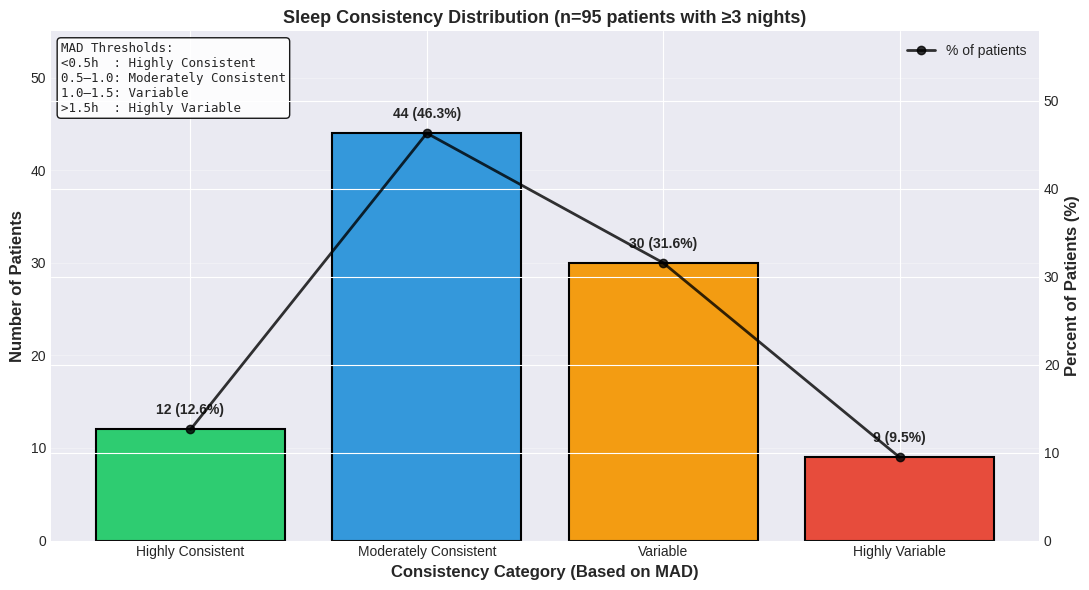

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 6))

categories = ['Highly Consistent', 'Moderately Consistent', 'Variable', 'Highly Variable']
counts = [len(df_variability[df_variability['consistency_category'] == cat]) for cat in categories]
n_pat = len(df_variability)

colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
x = np.arange(len(categories))

bars = ax.bar(x, counts, color=colors, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
ax.set_xlabel('Consistency Category (Based on MAD)', fontsize=12, fontweight='bold')
ax.set_title(f'Sleep Consistency Distribution (n={n_pat} patients with ≥3 nights)',
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=0)
ax.grid(axis='y', alpha=0.3)

# Headroom for labels
ymax = max(1, max(counts))
ax.set_ylim(0, ymax * 1.25)

# Labels: "count (pct)"
for bar, count in zip(bars, counts):
    pct = (count / n_pat) * 100 if n_pat else 0
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + ymax * 0.03,
            f'{count} ({pct:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# Secondary axis: % line
ax2 = ax.twinx()
percentages = [(c / n_pat) * 100 if n_pat else 0 for c in counts]
ax2.plot(x, percentages, marker='o', linewidth=2, color='black', alpha=0.8, label='% of patients')
ax2.set_ylabel('Percent of Patients (%)', fontsize=12, fontweight='bold')
ax2.set_ylim(0, max(5, max(percentages) * 1.25))
ax2.legend(loc='upper right')

# MAD thresholds box
threshold_text = (
    "MAD Thresholds:\n"
    "<0.5h  : Highly Consistent\n"
    "0.5–1.0: Moderately Consistent\n"
    "1.0–1.5: Variable\n"
    ">1.5h  : Highly Variable"
)
ax.text(0.01, 0.98, threshold_text, transform=ax.transAxes,
        fontsize=9, va='top', ha='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
        family='monospace')

plt.tight_layout()
plt.show()


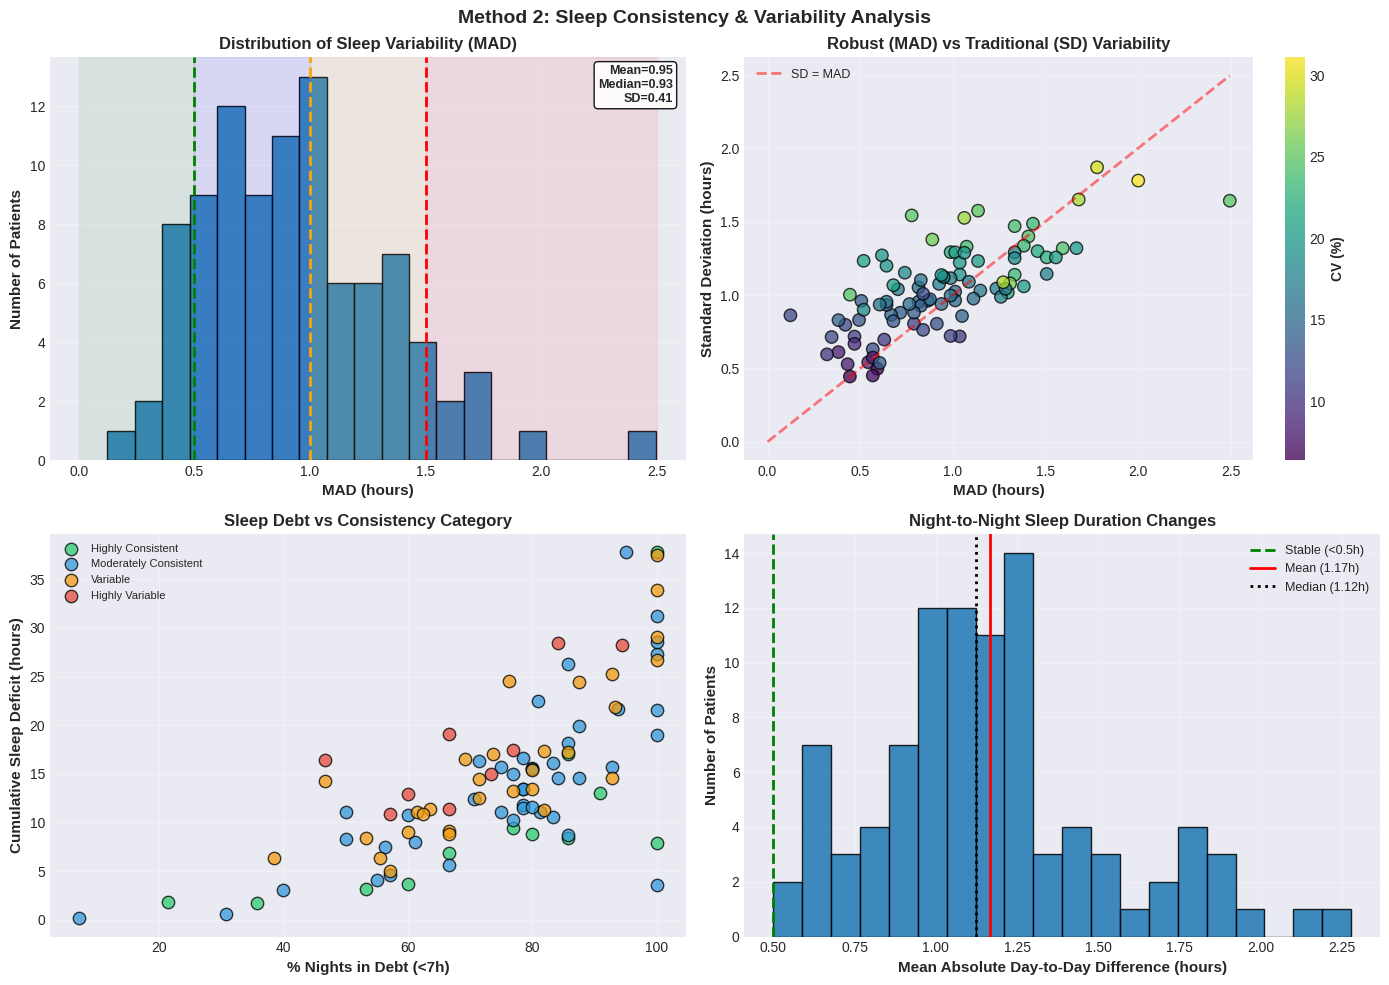

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
mad_vals = df_variability['mad'].dropna().values

ax1.hist(mad_vals, bins=20, edgecolor='black', alpha=0.85)
ax1.axvline(0.5, linestyle='--', linewidth=2, color='green')
ax1.axvline(1.0, linestyle='--', linewidth=2, color='orange')
ax1.axvline(1.5, linestyle='--', linewidth=2, color='red')

# Shaded zones
ax1.axvspan(0, 0.5, alpha=0.08, color='green')
ax1.axvspan(0.5, 1.0, alpha=0.08, color='blue')
ax1.axvspan(1.0, 1.5, alpha=0.08, color='orange')
ax1.axvspan(1.5, max(2.5, mad_vals.max() if len(mad_vals) else 2.5), alpha=0.08, color='red')

ax1.set_xlabel('MAD (hours)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Patients', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Sleep Variability (MAD)', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

# stats annotation
ax1.text(0.98, 0.98,
         f'Mean={np.mean(mad_vals):.2f}\nMedian={np.median(mad_vals):.2f}\nSD={np.std(mad_vals, ddof=1):.2f}',
         transform=ax1.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
         fontweight='bold', fontsize=9)

ax2 = axes[0, 1]
scatter = ax2.scatter(df_variability['mad'], df_variability['std'],
                      c=df_variability['cv'], cmap='viridis',
                      s=80, edgecolor='black', linewidth=1, alpha=0.75)

lim_max = max(df_variability['mad'].max(), df_variability['std'].max())
ax2.plot([0, lim_max], [0, lim_max], 'r--', linewidth=2, alpha=0.5, label='SD = MAD')

ax2.set_xlabel('MAD (hours)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Standard Deviation (hours)', fontsize=11, fontweight='bold')
ax2.set_title('Robust (MAD) vs Traditional (SD) Variability', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.legend(fontsize=9)

cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('CV (%)', fontsize=10, fontweight='bold')

ax3 = axes[1, 0]
colors_cat = {'Highly Consistent': '#2ecc71', 'Moderately Consistent': '#3498db',
              'Variable': '#f39c12', 'Highly Variable': '#e74c3c'}

for cat in ['Highly Consistent', 'Moderately Consistent', 'Variable', 'Highly Variable']:
    data = df_variability[df_variability['consistency_category'] == cat]
    ax3.scatter(data['days_in_debt_pct'], data['cumulative_deficit'],
                label=cat, color=colors_cat[cat], s=80,
                edgecolor='black', linewidth=1, alpha=0.75)

ax3.set_xlabel('% Nights in Debt (<7h)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Cumulative Sleep Deficit (hours)', fontsize=11, fontweight='bold')
ax3.set_title('Sleep Debt vs Consistency Category', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3)
ax3.legend(fontsize=8, loc='upper left')

ax4 = axes[1, 1]
mean_diffs = df_variability['mean_abs_diff'].dropna().values

ax4.hist(mean_diffs, bins=20, edgecolor='black', alpha=0.85)
ax4.axvline(0.5, linestyle='--', linewidth=2, color='green', label='Stable (<0.5h)')
ax4.axvline(np.mean(mean_diffs), linestyle='-', linewidth=2, color='red', label=f'Mean ({np.mean(mean_diffs):.2f}h)')
ax4.axvline(np.median(mean_diffs), linestyle=':', linewidth=2, color='black', label=f'Median ({np.median(mean_diffs):.2f}h)')

ax4.set_xlabel('Mean Absolute Day-to-Day Difference (hours)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Number of Patients', fontsize=11, fontweight='bold')
ax4.set_title('Night-to-Night Sleep Duration Changes', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)
ax4.legend(fontsize=9)

plt.suptitle('Method 2: Sleep Consistency & Variability Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


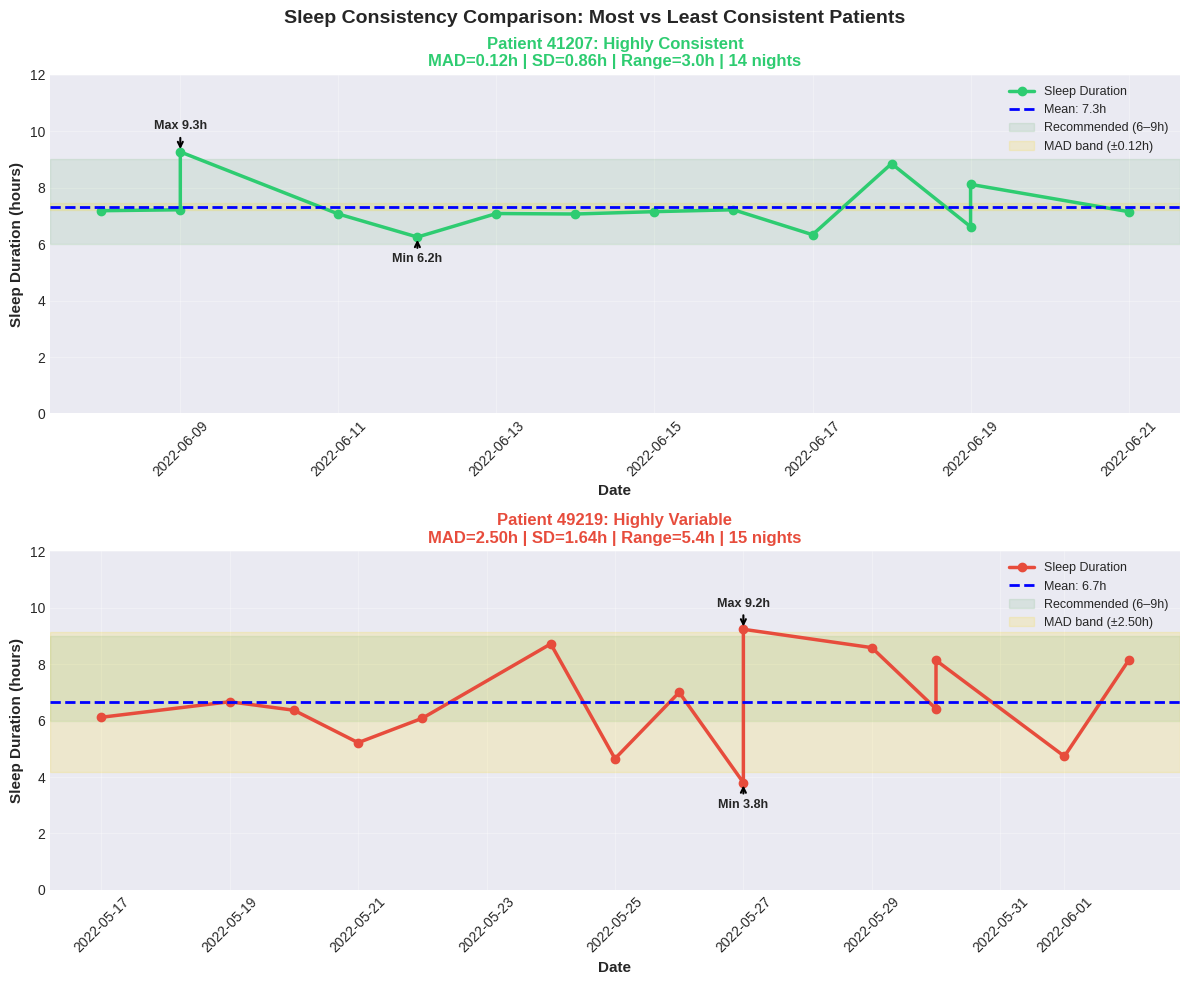

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

most_consistent = df_variability.nsmallest(1, 'mad')['patient_id'].values[0]
least_consistent = df_variability.nlargest(1, 'mad')['patient_id'].values[0]

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

for idx, (patient_id, ax) in enumerate(zip([most_consistent, least_consistent], axes)):
    patient_data = df_scored[df_scored['patient_id'] == patient_id].sort_values('date').copy()
    patient_data['date'] = pd.to_datetime(patient_data['date'])

    metrics = df_variability[df_variability['patient_id'] == patient_id].iloc[0]

    color_line = '#2ecc71' if idx == 0 else '#e74c3c'

    ax.plot(patient_data['date'], patient_data['total_sleep_hours'],
            marker='o', linewidth=2.5, markersize=6,
            color=color_line, label='Sleep Duration')

    mean_sleep = metrics['mean_sleep']
    ax.axhline(mean_sleep, color='blue', linestyle='--', linewidth=2,
               label=f'Mean: {mean_sleep:.1f}h')

    # Recommended range
    ax.axhspan(6, 9, alpha=0.08, color='green', label='Recommended (6–9h)')

    # MAD band
    ax.axhspan(mean_sleep - metrics['mad'], mean_sleep + metrics['mad'],
               alpha=0.15, color='gold', label=f'MAD band (±{metrics["mad"]:.2f}h)')

    consistency = metrics['consistency_category']
    ax.set_title(
        f'{patient_id.replace("A4F_", "Patient ")}: {consistency}\n'
        f'MAD={metrics["mad"]:.2f}h | SD={metrics["std"]:.2f}h | Range={metrics["range"]:.1f}h | {metrics["n_nights"]} nights',
        fontsize=12, fontweight='bold', color=color_line
    )

    ax.set_ylabel('Sleep Duration (hours)', fontsize=11, fontweight='bold')
    ax.set_ylim(0, 12)
    ax.grid(alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)

    # annotate max/min
    max_row = patient_data.loc[patient_data['total_sleep_hours'].idxmax()]
    min_row = patient_data.loc[patient_data['total_sleep_hours'].idxmin()]

    ax.annotate(f'Max {max_row["total_sleep_hours"]:.1f}h',
                xy=(max_row['date'], max_row['total_sleep_hours']),
                xytext=(max_row['date'], max_row['total_sleep_hours'] + 0.8),
                ha='center', fontweight='bold', fontsize=9,
                arrowprops=dict(arrowstyle='->', lw=1.5))

    ax.annotate(f'Min {min_row["total_sleep_hours"]:.1f}h',
                xy=(min_row['date'], min_row['total_sleep_hours']),
                xytext=(min_row['date'], min_row['total_sleep_hours'] - 0.9),
                ha='center', fontweight='bold', fontsize=9,
                arrowprops=dict(arrowstyle='->', lw=1.5))

    ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Sleep Consistency Comparison: Most vs Least Consistent Patients',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


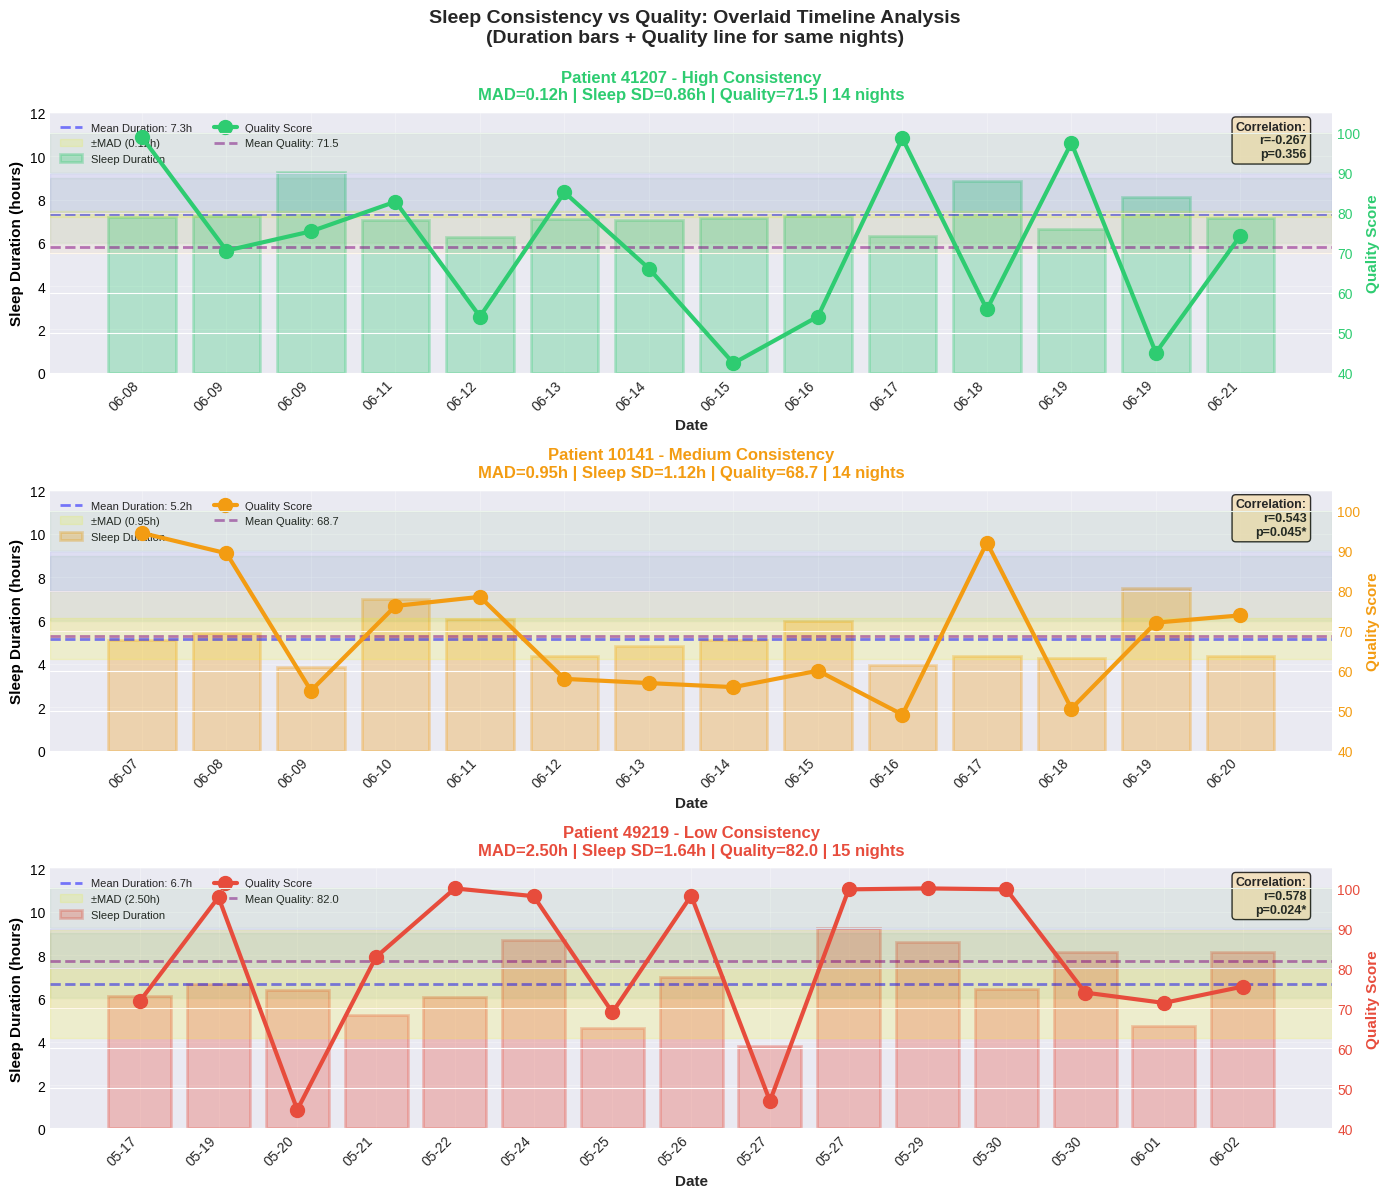


CONSISTENCY IMPACT ANALYSIS

Patient 41207 (High Consistency):
  Sleep Variability (MAD): 0.12h
  Sleep Range: 3.0h
  Mean Quality Score: 71.5
  Quality Range: 56.5
  Consistency Category: Highly Consistent
  Duration-Quality Alignment: 5/13 changes (38.5%)

Patient 10141 (Medium Consistency):
  Sleep Variability (MAD): 0.95h
  Sleep Range: 3.6h
  Mean Quality Score: 68.7
  Quality Range: 45.4
  Consistency Category: Moderately Consistent
  Duration-Quality Alignment: 8/13 changes (61.5%)

Patient 49219 (Low Consistency):
  Sleep Variability (MAD): 2.50h
  Sleep Range: 5.4h
  Mean Quality Score: 82.0
  Quality Range: 55.3
  Consistency Category: Highly Variable
  Duration-Quality Alignment: 10/14 changes (71.4%)


In [ ]:


# Select 3 patients with different consistency profiles
high_consistent = df_variability.nsmallest(1, 'mad')['patient_id'].values[0]
medium_consistent = df_variability[
    (df_variability['mad'] >= 0.7) & (df_variability['mad'] <= 1.0)
]['patient_id'].values[0] if len(df_variability[(df_variability['mad'] >= 0.7) & (df_variability['mad'] <= 1.0)]) > 0 else df_variability.iloc[len(df_variability)//2]['patient_id']
low_consistent = df_variability.nlargest(1, 'mad')['patient_id'].values[0]

selected_patients = [high_consistent, medium_consistent, low_consistent]
labels = ['High Consistency', 'Medium Consistency', 'Low Consistency']
colors = ['#2ecc71', '#f39c12', '#e74c3c']

# Create figure with overlaid graphs
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for idx, (patient_id, label, color) in enumerate(zip(selected_patients, labels, colors)):
    ax = axes[idx]

    # Get patient data
    patient_data = df_scored[df_scored['patient_id'] == patient_id].sort_values('date')
    metrics = df_variability[df_variability['patient_id'] == patient_id].iloc[0]

    # Create x-axis
    x = np.arange(len(patient_data))
    dates = [str(d)[-5:] for d in patient_data['date']]

    # Create twin axes for overlaying
    ax2 = ax.twinx()

    # Plot sleep duration (bars)
    bars = ax.bar(x, patient_data['total_sleep_hours'], alpha=0.3,
                  color=color, edgecolor=color, linewidth=2, label='Sleep Duration')

    # Plot quality score (line)
    line = ax2.plot(x, patient_data['quality_score'], marker='o', linewidth=3,
                    markersize=10, color=color, label='Quality Score', zorder=5)

    # Add mean lines
    mean_sleep = metrics['mean_sleep']
    mean_quality = df_combined[df_combined['patient_id'] == patient_id]['mean_quality'].values[0]

    ax.axhline(y=mean_sleep, color='blue', linestyle='--', linewidth=2,
               alpha=0.5, label=f'Mean Duration: {mean_sleep:.1f}h')
    ax2.axhline(y=mean_quality, color='purple', linestyle='--', linewidth=2,
                alpha=0.5, label=f'Mean Quality: {mean_quality:.1f}')

    # Add variability bands
    ax.axhspan(mean_sleep - metrics['mad'], mean_sleep + metrics['mad'],
               alpha=0.15, color='yellow', label=f'±MAD ({metrics["mad"]:.2f}h)')

    # Add recommended sleep range
    ax.axhspan(6, 9, alpha=0.05, color='green')

    # Quality thresholds
    ax2.axhspan(90, 100, alpha=0.05, color='green')
    ax2.axhspan(80, 90, alpha=0.05, color='blue')
    ax2.axhspan(70, 80, alpha=0.05, color='orange')

    # Labels and title
    ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('Sleep Duration (hours)', fontsize=11, fontweight='bold', color='black')
    ax2.set_ylabel('Quality Score', fontsize=11, fontweight='bold', color=color)

    title_text = (f'{patient_id.replace("A4F_", "Patient ")} - {label}\n'
                 f'MAD={metrics["mad"]:.2f}h | Sleep SD={metrics["std"]:.2f}h | '
                 f'Quality={mean_quality:.1f} | {metrics["n_nights"]} nights')
    ax.set_title(title_text, fontsize=12, fontweight='bold', color=color, pad=10)

    # Set x-axis
    ax.set_xticks(x[::max(1, len(x)//12)])
    ax.set_xticklabels([dates[i] for i in range(0, len(dates), max(1, len(x)//12))],
                       rotation=45, ha='right')

    # Set y-axis limits
    ax.set_ylim(0, 12)
    ax2.set_ylim(40, 105)

    # Grid
    ax.grid(alpha=0.3, zorder=0)

    # Combined legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left',
              fontsize=8, ncol=2)

    # Color y-axis labels
    ax.tick_params(axis='y', labelcolor='black')
    ax2.tick_params(axis='y', labelcolor=color)

    # Calculate correlation for this patient
    from scipy.stats import spearmanr
    corr, pval = spearmanr(patient_data['total_sleep_hours'], patient_data['quality_score'])

    # Add correlation box
    corr_text = f'Correlation:\nr={corr:.3f}'
    if pval < 0.05:
        corr_text += f'\np={pval:.3f}*'
    else:
        corr_text += f'\np={pval:.3f}'

    ax.text(0.98, 0.97, corr_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontweight='bold')

plt.suptitle('Sleep Consistency vs Quality: Overlaid Timeline Analysis\n(Duration bars + Quality line for same nights)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("CONSISTENCY IMPACT ANALYSIS")
print("="*70)

for patient_id, label in zip(selected_patients, labels):
    patient_data = df_scored[df_scored['patient_id'] == patient_id]
    metrics = df_variability[df_variability['patient_id'] == patient_id].iloc[0]

    print(f"\n{patient_id.replace('A4F_', 'Patient ')} ({label}):")
    print(f"  Sleep Variability (MAD): {metrics['mad']:.2f}h")
    print(f"  Sleep Range: {metrics['range']:.1f}h")
    print(f"  Mean Quality Score: {patient_data['quality_score'].mean():.1f}")
    print(f"  Quality Range: {patient_data['quality_score'].max() - patient_data['quality_score'].min():.1f}")
    print(f"  Consistency Category: {metrics['consistency_category']}")

    # Calculate how often duration and quality move together
    duration_changes = np.diff(patient_data.sort_values('date')['total_sleep_hours'])
    quality_changes = np.diff(patient_data.sort_values('date')['quality_score'])
    same_direction = np.sum((duration_changes > 0) == (quality_changes > 0))
    total_changes = len(duration_changes)

    print(f"  Duration-Quality Alignment: {same_direction}/{total_changes} changes ({same_direction/total_changes*100:.1f}%)")

METHOD 4: TEMPORAL PATTERN ANALYSIS

Calculating temporal pattern metrics for all patients...
✅ Temporal metrics calculated for 91 patients
   (Excluded 4 patients with insufficient weekday/weekend data)

TEMPORAL PATTERN SUMMARY STATISTICS

Weekday vs Weekend Sleep Duration:
  Mean Weekday: 6.02h
  Mean Weekend: 6.43h
  Mean Weekend Recovery: 0.41h

Sleep Timing (Midpoint in hours from midnight):
  Mean Weekday Midpoint: 4.15h
  Mean Weekend Midpoint: 4.99h

Social Jetlag:
  Mean: 0.99h
  Median: 0.89h
  Range: 0.01 - 3.82h

Social Jetlag Distribution:
  Normal (<1h)      :  52 patients ( 57.1%)
  Moderate (1-2h)   :  32 patients ( 35.2%)
  High (>2h)        :   7 patients (  7.7%)

Sleep Regularity Index (SRI):
  Mean: 53.4%
  (Higher = more consistent day-to-day)


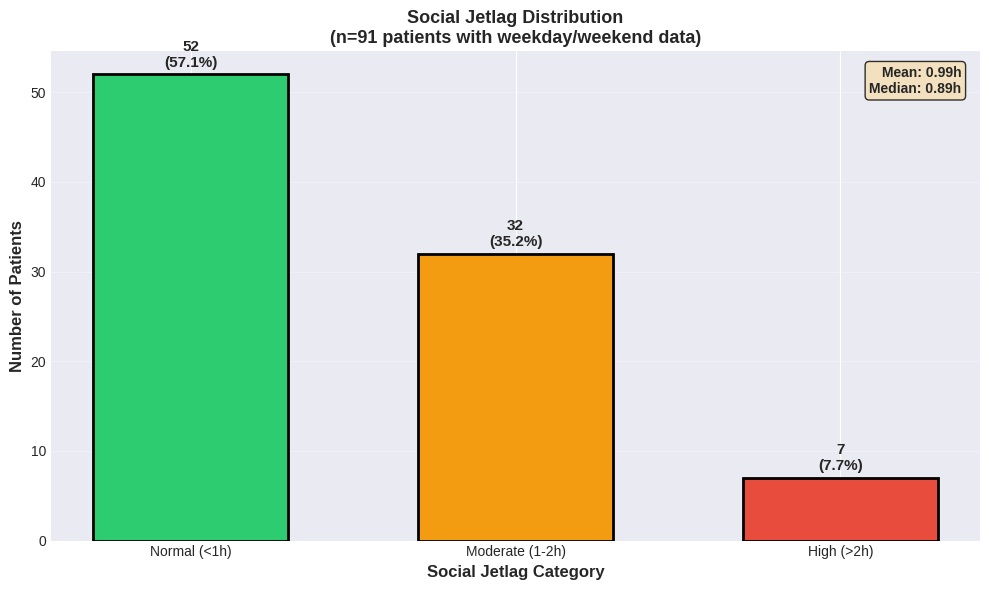

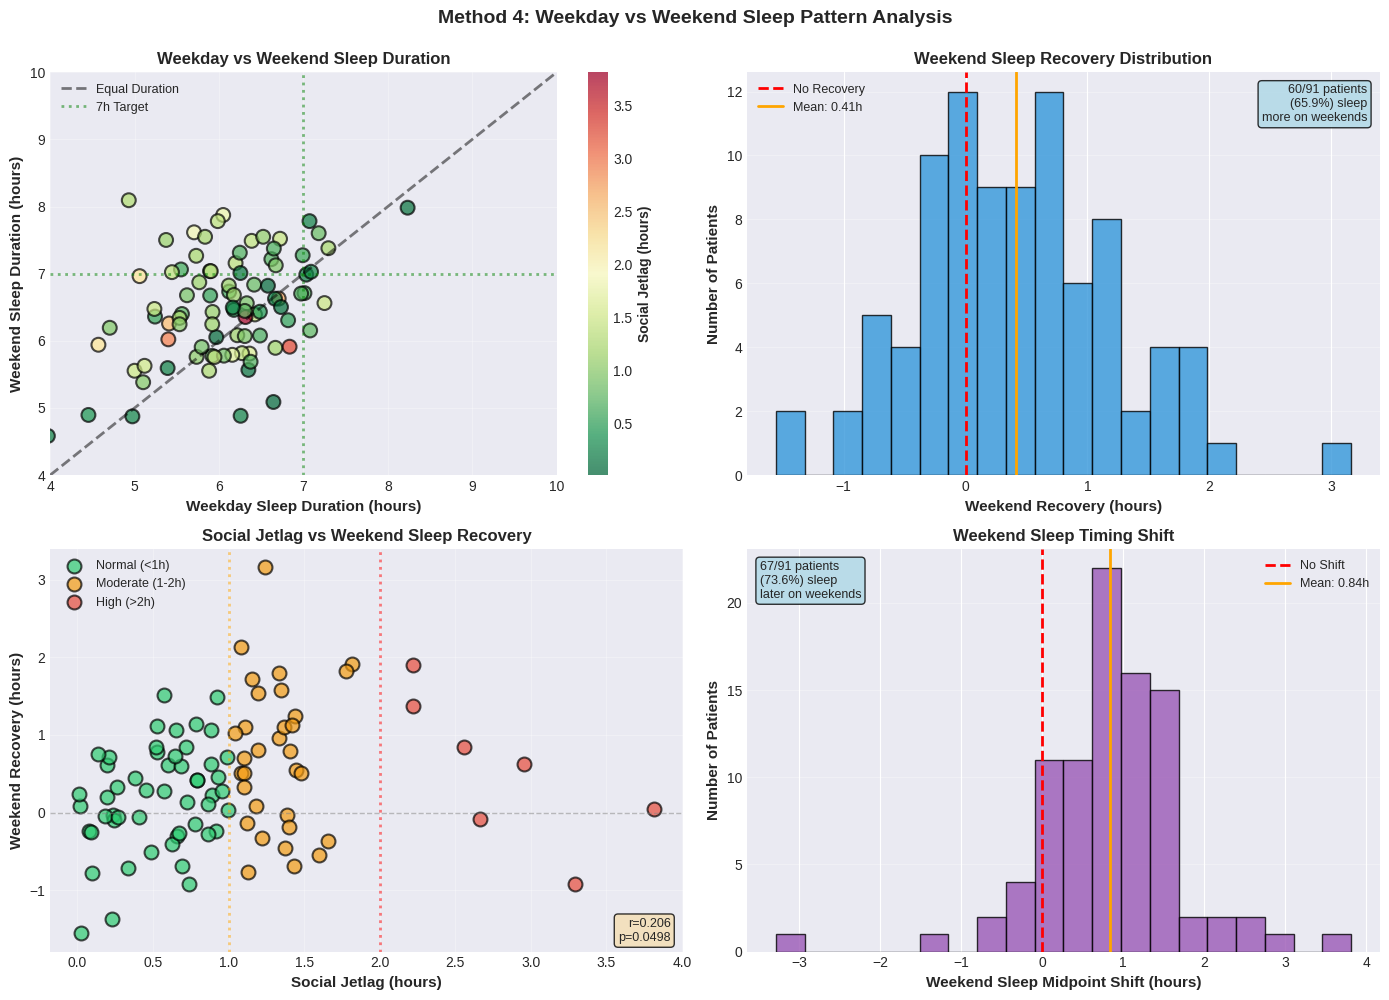

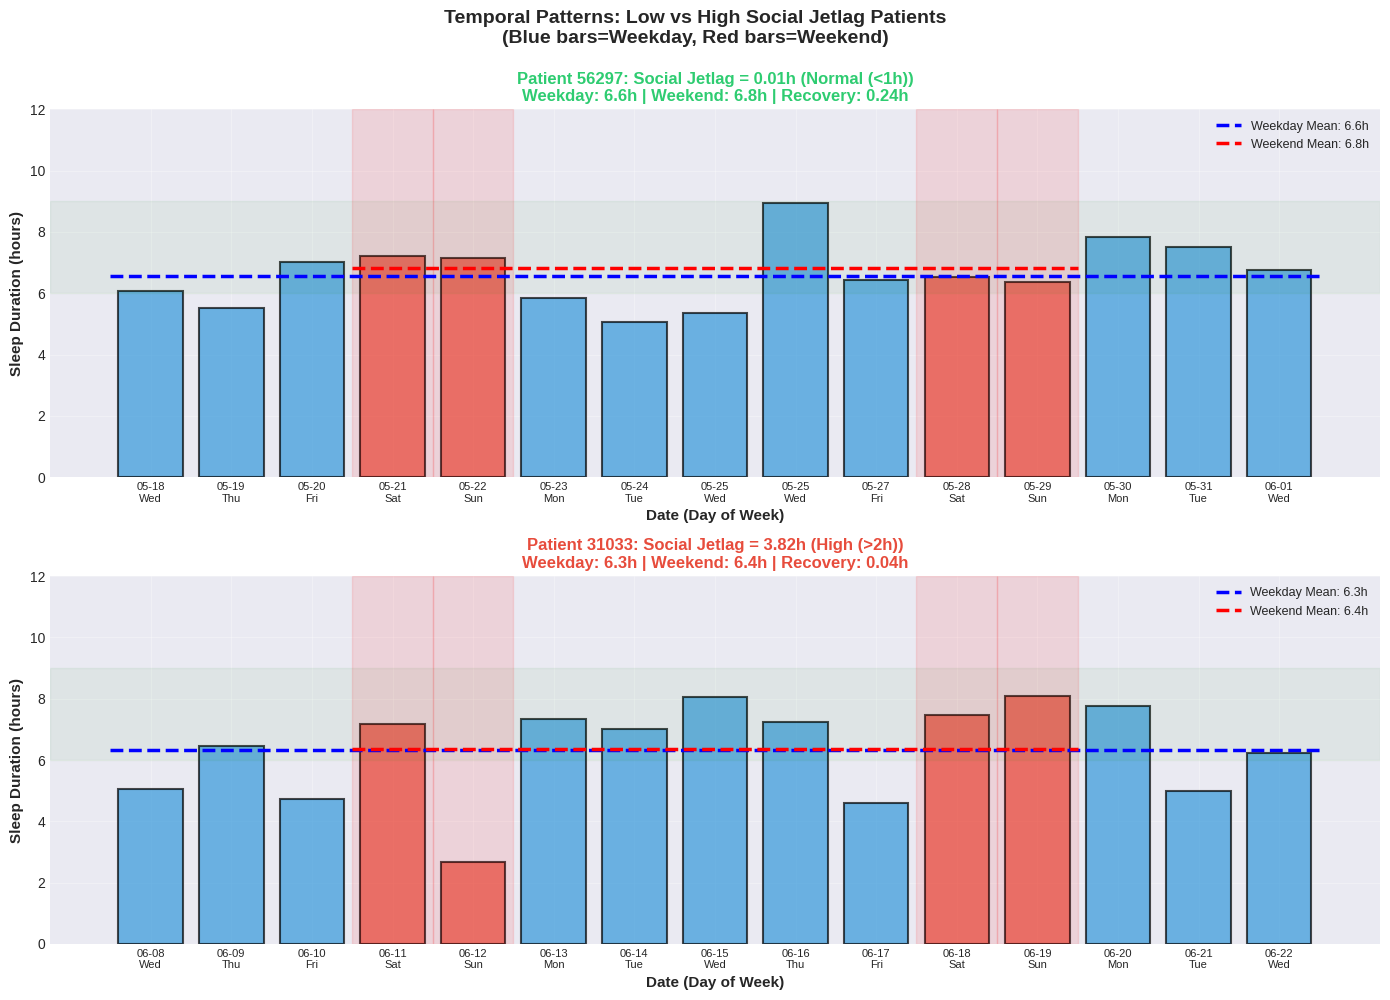

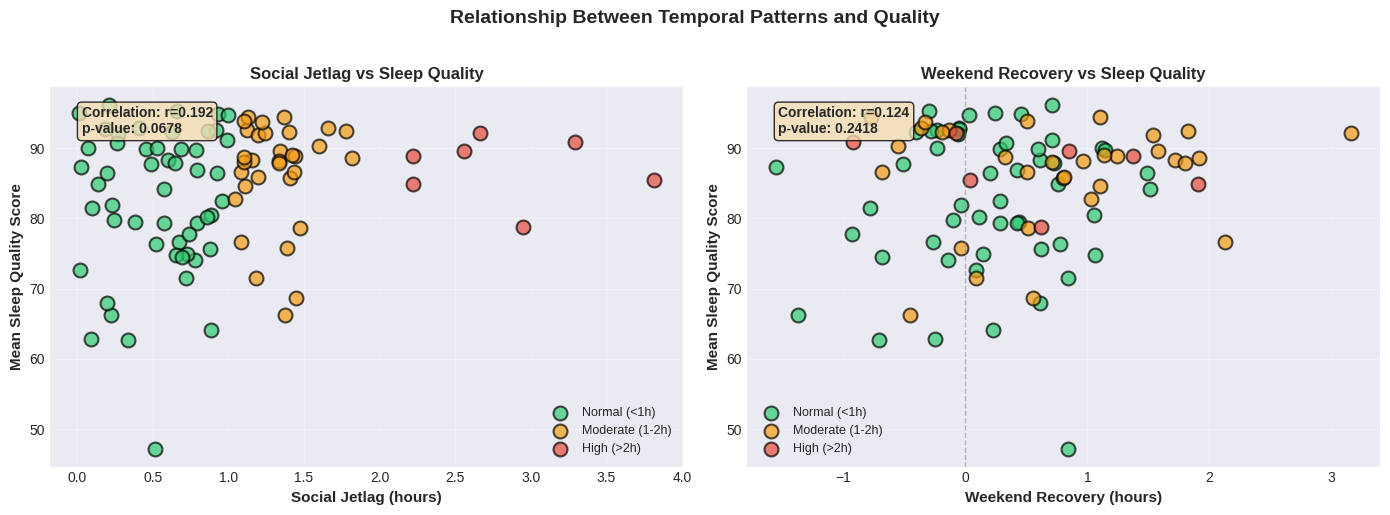


STATISTICAL ANALYSIS

Paired t-test: Weekday vs Weekend Sleep Duration
  Mean difference: 0.412h
  t-statistic: -4.791
  p-value: 0.0000
  Result: Significant difference (weekends ≠ weekdays) ✓

TOP 5 LOWEST SOCIAL JETLAG (Best Weekday/Weekend Consistency)
patient_id  social_jetlag  weekday_mean_duration  weekend_mean_duration  weekend_recovery  mean_quality
 A4F_56297           0.01                   6.58                   6.82              0.24         94.98
 A4F_20573           0.02                   5.97                   6.05              0.09         72.62
 A4F_91594           0.02                   6.64                   5.09             -1.56         87.35
 A4F_70954           0.07                   6.74                   6.50             -0.23         89.98
 A4F_80622           0.09                   8.24                   7.98             -0.25         62.83

TOP 5 HIGHEST SOCIAL JETLAG (Worst Weekday/Weekend Misalignment)
patient_id  social_jetlag  weekday_mean_duration  we

In [ ]:


print("="*70)
print("METHOD 4: TEMPORAL PATTERN ANALYSIS")
print("="*70)


def calculate_sleep_midpoint(start_datetime, duration_minutes):
    """Calculate the midpoint of a sleep period."""
    from datetime import timedelta
    midpoint = start_datetime + timedelta(minutes=duration_minutes/2)
    # Convert to hours from midnight
    hours_from_midnight = midpoint.hour + midpoint.minute/60
    # Adjust for sleep periods that cross midnight
    if hours_from_midnight < 12:  # Likely a sleep midpoint (e.g., 3 AM)
        return hours_from_midnight
    else:  # Bedtime after midnight (e.g., 23:00 = -1h from midnight)
        return hours_from_midnight - 24

def calculate_temporal_metrics(patient_data):
    """
    Calculate temporal pattern metrics for one patient.

    Parameters:
    -----------
    patient_data : DataFrame
        Sleep data for single patient with datetime columns

    Returns:
    --------
    metrics : dict
        Dictionary containing temporal metrics
    """
    # Add day of week
    patient_data = patient_data.copy()
    patient_data['day_of_week'] = patient_data['start_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
    patient_data['is_weekend'] = patient_data['day_of_week'].isin([5, 6])  # Saturday, Sunday

    # Calculate sleep midpoints (in hours from midnight)
    patient_data['sleep_midpoint'] = patient_data.apply(
        lambda row: calculate_sleep_midpoint(row['start_datetime'], row['duration']), axis=1
    )

    # Separate weekday and weekend
    weekday_data = patient_data[~patient_data['is_weekend']]
    weekend_data = patient_data[patient_data['is_weekend']]

    # Need at least 2 weekday and 2 weekend nights
    if len(weekday_data) < 2 or len(weekend_data) < 2:
        return None

    # Basic metrics
    weekday_mean_duration = weekday_data['total_sleep_hours'].mean()
    weekend_mean_duration = weekend_data['total_sleep_hours'].mean()

    weekday_mean_midpoint = weekday_data['sleep_midpoint'].mean()
    weekend_mean_midpoint = weekend_data['sleep_midpoint'].mean()

    # Social Jetlag: difference in sleep midpoint between weekend and weekday
    social_jetlag = abs(weekend_mean_midpoint - weekday_mean_midpoint)

    # Weekend Recovery: additional sleep on weekends
    weekend_recovery = weekend_mean_duration - weekday_mean_duration

    # Sleep Regularity Index (simplified version)
    # Measures day-to-day consistency across the week
    all_durations = patient_data.sort_values('date')['total_sleep_hours'].values
    if len(all_durations) >= 7:
        # Calculate probability that two consecutive days have similar sleep
        similar_days = np.sum(np.abs(np.diff(all_durations)) < 1.0)  # <1h difference
        sri = (similar_days / (len(all_durations) - 1)) * 100
    else:
        sri = None

    # Weekday variability
    weekday_std = weekday_data['total_sleep_hours'].std()
    weekend_std = weekend_data['total_sleep_hours'].std()

    # Timing consistency
    weekday_timing_std = weekday_data['sleep_midpoint'].std()
    weekend_timing_std = weekend_data['sleep_midpoint'].std()

    metrics = {
        'n_weekdays': len(weekday_data),
        'n_weekends': len(weekend_data),
        'weekday_mean_duration': weekday_mean_duration,
        'weekend_mean_duration': weekend_mean_duration,
        'weekday_mean_midpoint': weekday_mean_midpoint,
        'weekend_mean_midpoint': weekend_mean_midpoint,
        'social_jetlag': social_jetlag,
        'weekend_recovery': weekend_recovery,
        'sleep_regularity_index': sri,
        'weekday_duration_std': weekday_std,
        'weekend_duration_std': weekend_std,
        'weekday_timing_std': weekday_timing_std,
        'weekend_timing_std': weekend_timing_std,
    }

    return metrics

def classify_social_jetlag(sj):
    """Classify social jetlag severity."""
    if sj < 1.0:
        return 'Normal (<1h)'
    elif sj < 2.0:
        return 'Moderate (1-2h)'
    else:
        return 'High (>2h)'

# Calculate temporal metrics for all patients
print("\nCalculating temporal pattern metrics for all patients...")

temporal_results = []
for patient_id in df_scored['patient_id'].unique():
    patient_data = df_scored[df_scored['patient_id'] == patient_id].sort_values('date')

    metrics = calculate_temporal_metrics(patient_data)
    if metrics is not None:
        metrics['patient_id'] = patient_id
        metrics['social_jetlag_category'] = classify_social_jetlag(metrics['social_jetlag'])
        temporal_results.append(metrics)

df_temporal = pd.DataFrame(temporal_results)

print(f"✅ Temporal metrics calculated for {len(df_temporal)} patients")
print(f"   (Excluded {df_scored['patient_id'].nunique() - len(df_temporal)} patients with insufficient weekday/weekend data)")


print("\n" + "="*70)
print("TEMPORAL PATTERN SUMMARY STATISTICS")
print("="*70)

print(f"\nWeekday vs Weekend Sleep Duration:")
print(f"  Mean Weekday: {df_temporal['weekday_mean_duration'].mean():.2f}h")
print(f"  Mean Weekend: {df_temporal['weekend_mean_duration'].mean():.2f}h")
print(f"  Mean Weekend Recovery: {df_temporal['weekend_recovery'].mean():.2f}h")

print(f"\nSleep Timing (Midpoint in hours from midnight):")
print(f"  Mean Weekday Midpoint: {df_temporal['weekday_mean_midpoint'].mean():.2f}h")
print(f"  Mean Weekend Midpoint: {df_temporal['weekend_mean_midpoint'].mean():.2f}h")

print(f"\nSocial Jetlag:")
print(f"  Mean: {df_temporal['social_jetlag'].mean():.2f}h")
print(f"  Median: {df_temporal['social_jetlag'].median():.2f}h")
print(f"  Range: {df_temporal['social_jetlag'].min():.2f} - {df_temporal['social_jetlag'].max():.2f}h")

print(f"\nSocial Jetlag Distribution:")
for category in ['Normal (<1h)', 'Moderate (1-2h)', 'High (>2h)']:
    count = (df_temporal['social_jetlag_category'] == category).sum()
    pct = (count / len(df_temporal)) * 100
    print(f"  {category:18s}: {count:3d} patients ({pct:5.1f}%)")

if df_temporal['sleep_regularity_index'].notna().sum() > 0:
    print(f"\nSleep Regularity Index (SRI):")
    print(f"  Mean: {df_temporal['sleep_regularity_index'].mean():.1f}%")
    print(f"  (Higher = more consistent day-to-day)")

fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Normal (<1h)', 'Moderate (1-2h)', 'High (>2h)']
counts = [len(df_temporal[df_temporal['social_jetlag_category'] == cat]) for cat in categories]
colors = ['#2ecc71', '#f39c12', '#e74c3c']

bars = ax.bar(categories, counts, color=colors, edgecolor='black', linewidth=2, width=0.6)
ax.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
ax.set_xlabel('Social Jetlag Category', fontsize=12, fontweight='bold')
ax.set_title(f'Social Jetlag Distribution\n(n={len(df_temporal)} patients with weekday/weekend data)',
              fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add count and percentage labels
for bar, count in zip(bars, counts):
    height = bar.get_height()
    pct = (count / len(df_temporal)) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{count}\n({pct:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add statistics box
stats_text = f'Mean: {df_temporal["social_jetlag"].mean():.2f}h\nMedian: {df_temporal["social_jetlag"].median():.2f}h'
ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontweight='bold')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Weekday vs Weekend Duration
ax1 = axes[0, 0]
ax1.scatter(df_temporal['weekday_mean_duration'], df_temporal['weekend_mean_duration'],
           c=df_temporal['social_jetlag'], cmap='RdYlGn_r', s=100,
           edgecolor='black', linewidth=1.5, alpha=0.7)
ax1.plot([4, 10], [4, 10], 'k--', linewidth=2, alpha=0.5, label='Equal Duration')
ax1.axhline(y=7, color='green', linestyle=':', linewidth=2, alpha=0.5, label='7h Target')
ax1.axvline(x=7, color='green', linestyle=':', linewidth=2, alpha=0.5)

ax1.set_xlabel('Weekday Sleep Duration (hours)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Weekend Sleep Duration (hours)', fontsize=11, fontweight='bold')
ax1.set_title('Weekday vs Weekend Sleep Duration', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)
ax1.set_xlim(4, 10)
ax1.set_ylim(4, 10)

cbar = plt.colorbar(ax1.collections[0], ax=ax1)
cbar.set_label('Social Jetlag (hours)', fontsize=10, fontweight='bold')

# Plot 2: Weekend Recovery Distribution
ax2 = axes[0, 1]
recovery_values = df_temporal['weekend_recovery'].values
ax2.hist(recovery_values, bins=20, color='#3498db', edgecolor='black', alpha=0.8)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Recovery')
ax2.axvline(x=recovery_values.mean(), color='orange', linestyle='-', linewidth=2,
            label=f'Mean: {recovery_values.mean():.2f}h')

ax2.set_xlabel('Weekend Recovery (hours)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Patients', fontsize=11, fontweight='bold')
ax2.set_title('Weekend Sleep Recovery Distribution', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# Add annotation
positive_recovery = (recovery_values > 0).sum()
pct_positive = (positive_recovery / len(recovery_values)) * 100
ax2.text(0.98, 0.97, f'{positive_recovery}/{len(recovery_values)} patients\n({pct_positive:.1f}%) sleep\nmore on weekends',
         transform=ax2.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Plot 3: Social Jetlag vs Weekend Recovery
ax3 = axes[1, 0]
colors_cat = {'Normal (<1h)': '#2ecc71', 'Moderate (1-2h)': '#f39c12', 'High (>2h)': '#e74c3c'}

for cat in categories:
    data = df_temporal[df_temporal['social_jetlag_category'] == cat]
    ax3.scatter(data['social_jetlag'], data['weekend_recovery'], label=cat,
               color=colors_cat[cat], s=100, edgecolor='black',
               linewidth=1.5, alpha=0.7)

ax3.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax3.axvline(x=1, color='orange', linestyle=':', linewidth=2, alpha=0.5)
ax3.axvline(x=2, color='red', linestyle=':', linewidth=2, alpha=0.5)

ax3.set_xlabel('Social Jetlag (hours)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Weekend Recovery (hours)', fontsize=11, fontweight='bold')
ax3.set_title('Social Jetlag vs Weekend Sleep Recovery', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9, loc='upper left')
ax3.grid(alpha=0.3)

# Add correlation
from scipy.stats import pearsonr
corr, pval = pearsonr(df_temporal['social_jetlag'], df_temporal['weekend_recovery'])
ax3.text(0.98, 0.02, f'r={corr:.3f}\np={pval:.4f}',
         transform=ax3.transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 4: Sleep Timing Shift (Midpoint)
ax4 = axes[1, 1]
midpoint_shift = df_temporal['weekend_mean_midpoint'] - df_temporal['weekday_mean_midpoint']
ax4.hist(midpoint_shift, bins=20, color='#9b59b6', edgecolor='black', alpha=0.8)
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Shift')
ax4.axvline(x=midpoint_shift.mean(), color='orange', linestyle='-', linewidth=2,
            label=f'Mean: {midpoint_shift.mean():.2f}h')

ax4.set_xlabel('Weekend Sleep Midpoint Shift (hours)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Number of Patients', fontsize=11, fontweight='bold')
ax4.set_title('Weekend Sleep Timing Shift', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(axis='y', alpha=0.3)

# Add annotation
later_bedtime = (midpoint_shift > 0.5).sum()
pct_later = (later_bedtime / len(midpoint_shift)) * 100
ax4.text(0.02, 0.97, f'{later_bedtime}/{len(midpoint_shift)} patients\n({pct_later:.1f}%) sleep\nlater on weekends',
         transform=ax4.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.suptitle('Method 4: Weekday vs Weekend Sleep Pattern Analysis',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Select patients with different social jetlag profiles
low_sj_patient = df_temporal.nsmallest(1, 'social_jetlag')['patient_id'].values[0]
high_sj_patient = df_temporal.nlargest(1, 'social_jetlag')['patient_id'].values[0]

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

for idx, (patient_id, ax) in enumerate(zip([low_sj_patient, high_sj_patient], axes)):
    patient_data = df_scored[df_scored['patient_id'] == patient_id].sort_values('date').copy()
    patient_data['day_of_week'] = patient_data['start_datetime'].dt.dayofweek
    patient_data['is_weekend'] = patient_data['day_of_week'].isin([5, 6])
    patient_data['day_name'] = patient_data['start_datetime'].dt.day_name()

    metrics = df_temporal[df_temporal['patient_id'] == patient_id].iloc[0]

    # Create x-axis
    x = np.arange(len(patient_data))
    dates = [f"{d}\n{n[:3]}" for d, n in zip([str(dt)[-5:] for dt in patient_data['date']],
                                               patient_data['day_name'])]

    # Color by weekday/weekend
    colors = ['#e74c3c' if is_weekend else '#3498db' for is_weekend in patient_data['is_weekend']]

    # Plot sleep duration as bars
    bars = ax.bar(x, patient_data['total_sleep_hours'], color=colors,
                  edgecolor='black', linewidth=1.5, alpha=0.7)

    # Add mean lines
    weekday_mean = metrics['weekday_mean_duration']
    weekend_mean = metrics['weekend_mean_duration']

    # Draw mean lines for weekday and weekend separately
    weekday_x = [i for i, is_we in enumerate(patient_data['is_weekend']) if not is_we]
    weekend_x = [i for i, is_we in enumerate(patient_data['is_weekend']) if is_we]

    if weekday_x:
        ax.hlines(y=weekday_mean, xmin=min(weekday_x)-0.5, xmax=max(weekday_x)+0.5,
                 color='blue', linestyle='--', linewidth=2.5, label=f'Weekday Mean: {weekday_mean:.1f}h')
    if weekend_x:
        ax.hlines(y=weekend_mean, xmin=min(weekend_x)-0.5, xmax=max(weekend_x)+0.5,
                 color='red', linestyle='--', linewidth=2.5, label=f'Weekend Mean: {weekend_mean:.1f}h')

    # Add recommended range
    ax.axhspan(6, 9, alpha=0.05, color='green')

    # Labels
    ax.set_xlabel('Date (Day of Week)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Sleep Duration (hours)', fontsize=11, fontweight='bold')

    title_color = '#2ecc71' if idx == 0 else '#e74c3c'
    sj_category = metrics['social_jetlag_category']
    ax.set_title(f'{patient_id.replace("A4F_", "Patient ")}: Social Jetlag = {metrics["social_jetlag"]:.2f}h ({sj_category})\n'
                 f'Weekday: {weekday_mean:.1f}h | Weekend: {weekend_mean:.1f}h | '
                 f'Recovery: {metrics["weekend_recovery"]:.2f}h',
                 fontsize=12, fontweight='bold', color=title_color)

    ax.set_xticks(x)
    ax.set_xticklabels(dates, fontsize=8)
    ax.set_ylim(0, 12)
    ax.grid(alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)

    # Add weekend shading
    for i, is_weekend in enumerate(patient_data['is_weekend']):
        if is_weekend:
            ax.axvspan(i-0.5, i+0.5, alpha=0.1, color='red')

plt.suptitle('Temporal Patterns: Low vs High Social Jetlag Patients\n(Blue bars=Weekday, Red bars=Weekend)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Merge with quality scores
patient_quality = df_scored.groupby('patient_id')['quality_score'].mean().reset_index()
patient_quality.columns = ['patient_id', 'mean_quality']
df_temporal_quality = pd.merge(df_temporal, patient_quality, on='patient_id')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Social Jetlag vs Quality
ax1 = axes[0]
for cat in categories:
    data = df_temporal_quality[df_temporal_quality['social_jetlag_category'] == cat]
    ax1.scatter(data['social_jetlag'], data['mean_quality'], label=cat,
               color=colors_cat[cat], s=100, edgecolor='black',
               linewidth=1.5, alpha=0.7)

ax1.set_xlabel('Social Jetlag (hours)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Mean Sleep Quality Score', fontsize=11, fontweight='bold')
ax1.set_title('Social Jetlag vs Sleep Quality', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

corr_sj, pval_sj = pearsonr(df_temporal_quality['social_jetlag'], df_temporal_quality['mean_quality'])
ax1.text(0.05, 0.95, f'Correlation: r={corr_sj:.3f}\np-value: {pval_sj:.4f}',
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontweight='bold')

# Plot 2: Weekend Recovery vs Quality
ax2 = axes[1]
for cat in categories:
    data = df_temporal_quality[df_temporal_quality['social_jetlag_category'] == cat]
    ax2.scatter(data['weekend_recovery'], data['mean_quality'], label=cat,
               color=colors_cat[cat], s=100, edgecolor='black',
               linewidth=1.5, alpha=0.7)

ax2.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax2.set_xlabel('Weekend Recovery (hours)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Mean Sleep Quality Score', fontsize=11, fontweight='bold')
ax2.set_title('Weekend Recovery vs Sleep Quality', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

corr_wr, pval_wr = pearsonr(df_temporal_quality['weekend_recovery'], df_temporal_quality['mean_quality'])
ax2.text(0.05, 0.95, f'Correlation: r={corr_wr:.3f}\np-value: {pval_wr:.4f}',
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontweight='bold')

plt.suptitle('Relationship Between Temporal Patterns and Quality',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

print("\n" + "="*70)
print("STATISTICAL ANALYSIS")
print("="*70)

# Paired t-test: Weekday vs Weekend duration
from scipy.stats import ttest_rel

# Create matched pairs
weekday_durations = []
weekend_durations = []

for patient_id in df_temporal['patient_id']:
    patient_data = df_scored[df_scored['patient_id'] == patient_id].copy()
    patient_data['is_weekend'] = patient_data['start_datetime'].dt.dayofweek.isin([5, 6])

    weekday_mean = patient_data[~patient_data['is_weekend']]['total_sleep_hours'].mean()
    weekend_mean = patient_data[patient_data['is_weekend']]['total_sleep_hours'].mean()

    weekday_durations.append(weekday_mean)
    weekend_durations.append(weekend_mean)

t_stat, p_val = ttest_rel(weekday_durations, weekend_durations)

print(f"\nPaired t-test: Weekday vs Weekend Sleep Duration")
print(f"  Mean difference: {np.mean(weekend_durations) - np.mean(weekday_durations):.3f}h")
print(f"  t-statistic: {t_stat:.3f}")
print(f"  p-value: {p_val:.4f}")
if p_val < 0.05:
    print(f"  Result: Significant difference (weekends ≠ weekdays) ✓")
else:
    print(f"  Result: No significant difference")

# Display top/bottom patients
print("\n" + "="*70)
print("TOP 5 LOWEST SOCIAL JETLAG (Best Weekday/Weekend Consistency)")
print("="*70)
top5_sj = df_temporal_quality.nsmallest(5, 'social_jetlag')[
    ['patient_id', 'social_jetlag', 'weekday_mean_duration', 'weekend_mean_duration',
     'weekend_recovery', 'mean_quality']].round(2)
print(top5_sj.to_string(index=False))

print("\n" + "="*70)
print("TOP 5 HIGHEST SOCIAL JETLAG (Worst Weekday/Weekend Misalignment)")
print("="*70)
bottom5_sj = df_temporal_quality.nlargest(5, 'social_jetlag')[
    ['patient_id', 'social_jetlag', 'weekday_mean_duration', 'weekend_mean_duration',
     'weekend_recovery', 'mean_quality']].round(2)
print(bottom5_sj.to_string(index=False))

# Save results
df_temporal_quality.to_csv('method4_temporal_patterns.csv', index=False)
print(f"\n💾 Method 4 results saved: method4_temporal_patterns.csv")

print("\n✅ Method 4 implementation complete!")